# Seminário Big Data 
## Covid - Vacinação x Mortes no RS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import datetime as dt
import array
import warnings
import dateutil
import argparse
import math

from datetime import date, datetime, timedelta
from matplotlib.colors import LinearSegmentedColormap


warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [2]:
# Faixas etárias utilizadas neste trabalho
faixa_etaria_rs = ['<1', '01-04', '05-09', '10-14', '15-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']

faixa_etaria_rs_adultos = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
faixa_etaria_rs_adultos_menor_60 = ['<20', '20-29', '30-39', '40-49', '50-59']
faixa_etaria_rs_adultos_maior_60 = ['60-69', '70-79', '80+']
faixa_etaria_rs_adultos_menor_70 = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69']
faixa_etaria_rs_adultos_maior_70 = ['70-79', '80+']

populacao_60_label = ['População < 60 Anos', 'População > 60 Anos']
populacao_70_label = ['População < 70 Anos', 'População > 70 Anos']

populacao_por_sexo_biologico_labels =  ['Masculino', 'Feminino', 'Não Informado']

# Dias para adquirir imunidade após a segunda dosee 
# https://butantan.gov.br/noticias/quanto-tempo-demora-para-adquirir-imunidade-apos-tomar-a-vacina-contra-a-covid-19
dias_imunidade_apos_segunda_dose = 15

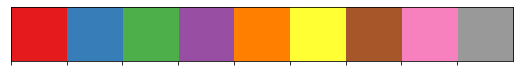

In [3]:
# Cores de cada faixa etária
# palette = sns.color_palette("Accent")
palette = sns.color_palette("Set1")
sns.palplot(palette)

# População Estimada pelo IBGE

In [4]:
# Importa dataset de projeção da população para 2020/2021
ibge_projecao_populacao_rw = pd.read_table('IBGE_Projecao_Poupacao_RS.csv', delimiter=';')

In [5]:
ibge_projecao_populacao_rw.head(10)

,Tipo,Faixa,2010,2011,2012,2013,2014,2015,2016,2017,...,2052,2053,2054,2055,2056,2057,2058,2059,2060,Unnamed: 53
0,Geral,Total,10963317,11014448,11066527,11119817,11175777,11229947,11280193,11329605,...,11307925,11261436,11213094,11162931,11111019,11057418,11002151,10945217,NaN,NaN
1,Geral,0-4,682720,672700,673534,679213,687053,699906,709530,712846,...,527458,524343,520950,517275,513314,509078,504593,499900,495057.0,NaN
2,Geral,5-9,776999,752113,730920,712999,695892,677636,667723,668648,...,537840,535105,532459,529818,527110,524249,521141,517756,514083.0,NaN
3,Geral,10-14,873692,862811,841096,814660,790792,771310,746552,725476,...,552499,547920,543847,540225,537009,534096,531364,528720,526085.0,NaN
4,Geral,15-19,887837,886928,885779,883116,877115,866713,855998,834464,...,577936,571320,565062,559146,553593,548504,543939,539879,536265.0,NaN
5,Geral,20-24,882939,878217,876495,876867,877588,877443,876758,875828,...,608672,601102,593659,586360,579205,572279,565690,559455,553563.0,NaN
6,Geral,25-29,906352,905575,897866,886104,875046,867679,863295,861886,...,638422,630677,622882,615111,607417,599785,592247,584838,577569.0,NaN
7,Geral,30-34,819460,835222,852975,870104,882790,888755,888342,881035,...,660561,655510,649650,643074,635887,628333,620628,612869,605138.0,NaN
8,Geral,35-39,755415,758986,766380,777056,790046,804478,820451,838398,...,664510,666586,665891,660868,655747,652340,647328,641512,634975.0,NaN
9,Geral,40-44,770872,762030,753321,746028,741837,741792,745653,753285,...,616489,622594,630789,643867,653759,657440,659536,658873,653908.0,NaN


In [6]:
# Deleta colunas que não são utilizadas neste trabalho
for coluna in ibge_projecao_populacao_rw.columns:
    if coluna not in ['Tipo', 'Faixa', '2020', '2021']:
        ibge_projecao_populacao_rw.drop(coluna, axis=1, inplace=True)

In [7]:
# Converte as faixas etárias conforme divulgação de dados do Covid do Rio Grande do Sul
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = ibge_projecao_populacao_rw['Faixa']
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '0-4', '<20', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '5-9', '<20', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '10-14', '<20', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '15-19', '<20', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '20-24', '20-29', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '25-29', '20-29', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '30-34', '30-39', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '35-39', '30-39', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '40-44', '40-49', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '45-49', '40-49', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '50-54', '50-59', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '55-59', '50-59', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '60-64', '60-69', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '65-69', '60-69', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '70-74', '70-79', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '75-79', '70-79', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '80-84', '80+', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '85-89', '80+', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])
ibge_projecao_populacao_rw['Faixa_Etaria_RS'] = np.where(ibge_projecao_populacao_rw['Faixa'] == '90+', '80+', ibge_projecao_populacao_rw['Faixa_Etaria_RS'])

In [8]:
# Deleta as faixas etáras não utilizadas neste trabalho
ibge_projecao_populacao = ibge_projecao_populacao_rw[ibge_projecao_populacao_rw['Faixa_Etaria_RS'].isin(faixa_etaria_rs_adultos)]

In [9]:
ibge_projecao_populacao.head(20)

,Tipo,Faixa,2020,2021,Faixa_Etaria_RS
1,Geral,0-4,708058,702546,<20
2,Geral,5-9,695260,704971,<20
3,Geral,10-14,672532,662720,<20
4,Geral,15-19,765231,740659,<20
5,Geral,20-24,857443,846967,20-29
6,Geral,25-29,863706,863302,20-29
7,Geral,30-34,852038,848007,30-39
8,Geral,35-39,874866,874753,30-39
9,Geral,40-44,791926,808047,40-49
10,Geral,45-49,727364,731505,40-49


In [10]:
ibge_projecao_populacao.loc[(ibge_projecao_populacao['Tipo'] == 'Homens'), 'Tipo'] = populacao_por_sexo_biologico_labels[0]
ibge_projecao_populacao.loc[(ibge_projecao_populacao['Tipo'] == 'Mulheres'), 'Tipo'] = populacao_por_sexo_biologico_labels[1]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


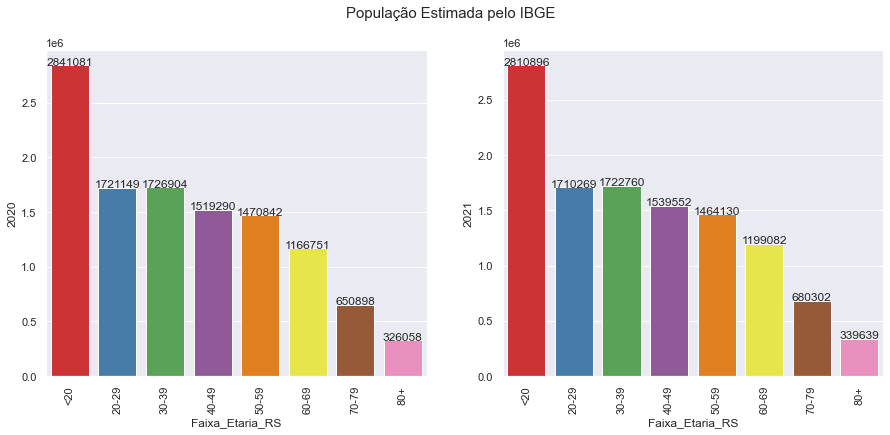

In [11]:
sns.set_theme(style='darkgrid')
fig,ax = plt.subplots(1, 2, figsize = (15,6))
sns.set_palette(palette)

graphic1 = sns.barplot(data=ibge_projecao_populacao[ibge_projecao_populacao['Tipo'] == 'Geral'], x='Faixa_Etaria_RS', y='2020', estimator=sum, ci=None, ax = ax[0])
graphic2 = sns.barplot(data=ibge_projecao_populacao[ibge_projecao_populacao['Tipo'] == 'Geral'], x='Faixa_Etaria_RS', y='2021', estimator=sum, ci=None, ax = ax[1])

plt.xticks(rotation=90)

fig.suptitle('População Estimada pelo IBGE', fontsize=15)

graphic1.set_xticklabels(graphic1.get_xticklabels(), rotation=90);
graphic2.set_xticklabels(graphic2.get_xticklabels(), rotation=90);

# Imprime o valor das barras
for i in np.arange(2):
    for p in ax[i].patches:
        height = p.get_height() 
        ax[i].text(p.get_x()+p.get_width()/2., height + 1,height ,ha="center")


In [12]:
populacao_por_sexo_biologico_2020 =[ibge_projecao_populacao[ibge_projecao_populacao['Tipo'] == populacao_por_sexo_biologico_labels[0]]['2020'].sum(),
                                    ibge_projecao_populacao[ibge_projecao_populacao['Tipo'] == populacao_por_sexo_biologico_labels[1]]['2020'].sum() ]

populacao_por_sexo_biologico_2021 =[ibge_projecao_populacao[ibge_projecao_populacao['Tipo'] == populacao_por_sexo_biologico_labels[0]]['2021'].sum(),
                                    ibge_projecao_populacao[ibge_projecao_populacao['Tipo'] == populacao_por_sexo_biologico_labels[1]]['2021'].sum() ]

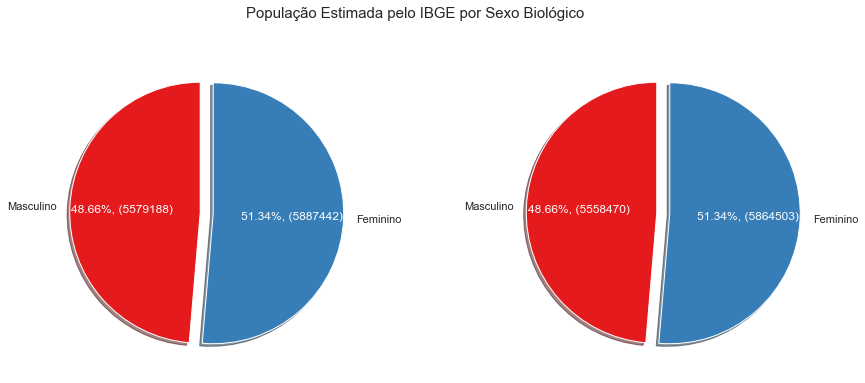

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (15,6))
explode = (0, 0.1) 

for i, ax in enumerate(axes):
    if i == 1:
        _, _, autotexts = ax.pie(populacao_por_sexo_biologico_2020, explode=explode, labels=populacao_por_sexo_biologico_labels[0:2], autopct=lambda p:f'{p:.2f}%, ({p*sum(populacao_por_sexo_biologico_2020)/100 :.0f})', shadow=True, startangle=90)
        for autotext in autotexts:
            autotext.set_color('white')
    else:
        _, _, autotexts = ax.pie(populacao_por_sexo_biologico_2021, explode=explode, labels=populacao_por_sexo_biologico_labels[0:2], autopct=lambda p:f'{p:.2f}%, ({p*sum(populacao_por_sexo_biologico_2021)/100 :.0f})', shadow=True, startangle=90)
        for autotext in autotexts:
            autotext.set_color('white')

# Utilizar o formato abaixo caso queria só mostrar o percentual
# autopct='%1.1f%%'        

fig.suptitle('População Estimada pelo IBGE por Sexo Biológico', fontsize=15)

plt.show()


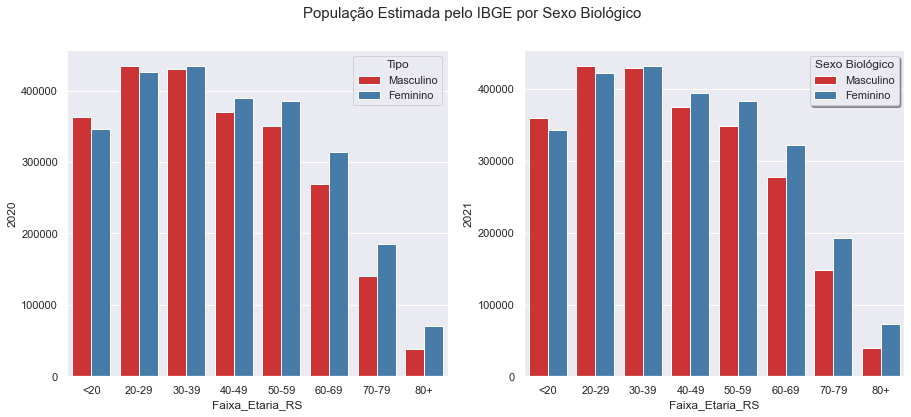

In [14]:
sns.set_theme(style='darkgrid')
fig, axes = plt.subplots(1, 2, figsize = (15,6))
sns.set_palette(palette)

sns.barplot(x='Faixa_Etaria_RS', y='2020', hue='Tipo', data=ibge_projecao_populacao[ibge_projecao_populacao['Tipo'] != 'Geral'], ci=None, ax = axes[0])

sns.barplot(x='Faixa_Etaria_RS', y='2021', hue='Tipo', data=ibge_projecao_populacao[ibge_projecao_populacao['Tipo'] != 'Geral'], ci=None, ax = axes[1])

#legend = axes[0].legend(shadow=True, title='Sexo Biológico')
legend = axes[1].legend(shadow=True, title='Sexo Biológico')

fig.suptitle('População Estimada pelo IBGE por Sexo Biológico', fontsize=15)

plt.show()

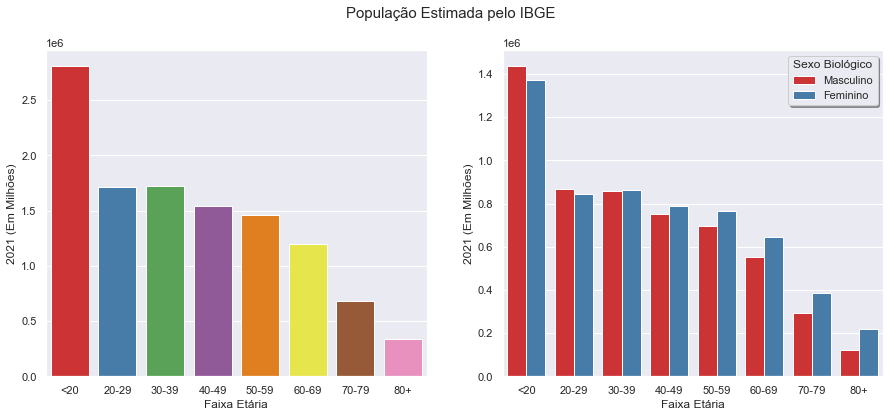

In [113]:
sns.set_theme(style='darkgrid')
fig, axes = plt.subplots(1, 2, figsize = (15,6))
sns.set_palette(palette)

sns.barplot(x='Faixa_Etaria_RS', y='2021', data=ibge_projecao_populacao[ibge_projecao_populacao['Tipo'] == 'Geral'], ci=None, ax = axes[0] ,estimator=sum)

sns.barplot(x='Faixa_Etaria_RS', y='2021', hue='Tipo', data=ibge_projecao_populacao[ibge_projecao_populacao['Tipo'] != 'Geral'], ci=None, ax = axes[1] , estimator=sum)

#legend = axes[0].legend(shadow=True, title='Sexo Biológico')
legend = axes[1].legend(shadow=True, title='Sexo Biológico')

fig.suptitle('População Estimada pelo IBGE', fontsize=15)

axes[0].set_ylabel('2021 (Em Milhões)', fontsize=12)
axes[1].set_ylabel('2021 (Em Milhões)', fontsize=12)
axes[0].set_xlabel('Faixa Etária', fontsize=12)
axes[1].set_xlabel('Faixa Etária', fontsize=12)

plt.savefig('Populacao_Estimada_IBGE.png', dpi=300)

plt.show()

In [108]:
ibge_projecao_populacao.

,Tipo,Faixa,2020,2021,Faixa_Etaria_RS
1,Geral,0-4,708058,702546,<20
2,Geral,5-9,695260,704971,<20
3,Geral,10-14,672532,662720,<20
4,Geral,15-19,765231,740659,<20
5,Geral,20-24,857443,846967,20-29
6,Geral,25-29,863706,863302,20-29
7,Geral,30-34,852038,848007,30-39
8,Geral,35-39,874866,874753,30-39
9,Geral,40-44,791926,808047,40-49
10,Geral,45-49,727364,731505,40-49


In [16]:
# TODO - contagem por ano
contagem_por_ano = ibge_projecao_populacao[ibge_projecao_populacao['Tipo'] != 'Geral'].groupby(['Tipo', 'Faixa']).sum().unstack()

contagem_por_ano

2020                                                          \
Faixa         0-4   10-14   15-19   20-24   25-29   30-34   35-39   40-44   
Tipo                                                                        
Feminino   345608  328332  373858  422176  429436  425981  442017  404906   
Masculino  362450  344200  391373  435267  434270  426057  432849  387020   

                           ...    2021                                  \
Faixa       45-49     5-9  ...     5-9   50-54   55-59   60-64   65-69   
Tipo                       ...                                           
Feminino   374148  339418  ...  344151  378929  387968  351549  292978   
Masculino  353216  355842  ...  360820  348516  348717  308000  246555   

                                                 
Faixa       70-74   75-79   80-84  85-89    90+  
Tipo                                             
Feminino   227101  158426  107395  64284  47765  
Masculino  180109  114666   67974  34058  18163  

[2 rows x 38 columns]

In [17]:
contagem_por_ano_com_geral = ibge_projecao_populacao.groupby(['Tipo', 'Faixa']).sum().unstack()

contagem_por_ano_com_geral

2020                                                          \
Faixa         0-4   10-14   15-19   20-24   25-29   30-34   35-39   40-44   
Tipo                                                                        
Feminino   345608  328332  373858  422176  429436  425981  442017  404906   
Geral      708058  672532  765231  857443  863706  852038  874866  791926   
Masculino  362450  344200  391373  435267  434270  426057  432849  387020   

                           ...    2021                                  \
Faixa       45-49     5-9  ...     5-9   50-54   55-59   60-64   65-69   
Tipo                       ...                                           
Feminino   374148  339418  ...  344151  378929  387968  351549  292978   
Geral      727364  695260  ...  704971  727445  736685  659549  539533   
Masculino  353216  355842  ...  360820  348516  348717  308000  246555   

                                                 
Faixa       70-74   75-79   80-84  85-89    90+  
Tipo                                             
Feminino   227101  158426  107395  64284  47765  
Geral      407210  273092  175369  98342  65928  
Masculino  180109  114666   67974  34058  18163  

[3 rows x 38 columns]

# Vacinação

In [18]:
# Importa dataset de vacinação do RS - Brasil
vacinacao_rs = pd.read_table('Vacinacao_RS_20210704.csv', delimiter=';')

In [19]:
vacinacao_rs.head(10)

,document_id,paciente_id,paciente_idade,paciente_datanascimento,paciente_enumsexobiologico,paciente_racacor_codigo,paciente_racacor_valor,paciente_endereco_coibgemunicipio,paciente_endereco_copais,paciente_endereco_nmmunicipio,...,vacina_lote,vacina_fabricante_nome,vacina_fabricante_referencia,vacina_dataaplicacao,vacina_descricao_dose,vacina_codigo,vacina_nome,sistema_origem,data_importacao_rnds,id_sistema_origem
0,d4f3f33a-2bbe-4b35-95a0-b0a79f2ab0c7-i0b0,46238816e607008e9a7eec2695f0b279abc95c2cc8c46d...,57,1964-03-30,M,1,BRANCA,430760.0,10.0,ESTANCIA VELHA,...,213VCD029W,FUNDACAO OSWALDO CRUZ,Organization/33781055000135,2021-05-06,1ª Dose,85,Vacina Covid-19 - Covishield,Novo PNI,2021-05-06T16:58:18.000Z,16341
1,31bd9ed5-a5d3-47d0-95d2-ceeb92a86046-i0b0,9bd081c1a0c9a4bbda6cb4d8e26ce6924aa6d191db3bb9...,70,1950-07-31,M,1,BRANCA,430780.0,10.0,ESTRELA,...,210085,FUNDACAO BUTANTAN,Organization/61189445000156,2021-03-24,1ª Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-03-24T22:37:40.000Z,16341
2,e73b142e-6860-40c2-9741-d1c5ede3878f-i0b0,d74200e886c6bc7e4fda3ec8547fd8fe7deb5f92d6156f...,54,1967-01-24,M,1,BRANCA,432032.0,10.0,SENADOR SALGADO FILHO,...,EW0195,MINISTERIO DA SAUDE,Organization/00394544000851,2021-05-25,1ª Dose,87,Vacina covid-19 - BNT162b2 - BioNTech/Fosun Ph...,Novo PNI,2021-05-25T19:34:30.000Z,16341
3,6d441b8b-3870-42e6-a86d-aa9985ac1ebe-i0b0,a6e948a9b9f8861ce695aa731d36df7b24b9a5a9b4c868...,68,1952-11-24,M,1,BRANCA,431440.0,10.0,PELOTAS,...,210085,FUNDACAO BUTANTAN,Organization/61189445000156,2021-04-01,1ª Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-04-07T12:14:49.000Z,16341
4,d4f96c8d-2d1c-4915-82c8-413bf2fa75fb-i0b0,f663fffba16133eb18898b67121dabfb657b495608320d...,73,1947-09-29,F,99,SEM INFORMACAO,430510.0,10.0,CAXIAS DO SUL,...,213VCD006ZVA,FUNDACAO OSWALDO CRUZ,Organization/33781055000135,2021-04-13,1ª Dose,85,Vacina Covid-19 - Covishield,Novo PNI,2021-04-23T09:09:44.000Z,16341
5,987b72b8-961b-4c93-9d57-182b7b8bd955-i0b0,8e44c5ffc6aa795a7a369c7504ea43d46398bcf4e15669...,76,1944-10-25,F,1,BRANCA,430910.0,10.0,GRAMADO,...,210051,FUNDACAO BUTANTAN,Organization/61189445000156,2021-03-18,1ª Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-03-18T12:46:52.000Z,16341
6,06f88f13-8f47-420a-86bd-d4d4489ad192-i0b0,fd57f39f25a234fc44bcfe8bf6b039aea4e87393fead45...,63,1958-01-10,M,1,BRANCA,430940.0,10.0,GUAPORE,...,213VCD006ZVA,FUNDACAO OSWALDO CRUZ,Organization/33781055000135,2021-04-12,1ª Dose,85,Vacina Covid-19 - Covishield,Novo PNI,2021-04-14T20:27:03.000Z,16341
7,2616f808-50a5-4d5a-a1b2-8aa0b72cbd15-i0b0,c15d85c73a4ffa1fd9edabeec9aded89238203cf086e34...,19,2001-08-23,M,5,INDIGENA,432185.0,10.0,TRES PALMEIRAS,...,202010020,FUNDACAO BUTANTAN,Organization/61189445000156,2021-02-24,1ª Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-02-24T17:13:01.000Z,16341
8,baeaea11-82ac-4026-93c3-2ca268a9f955-i0b0,f9bbe6eebd5400055127eee33adff092fd1df66ec78f98...,29,1991-04-11,M,1,BRANCA,431370.0,10.0,PALMEIRA DAS MISSOES,...,212VCD001ZVA,FUNDACAO OSWALDO CRUZ,Organization/33781055000135,2021-04-03,1ª Dose,85,Vacina Covid-19 - Covishield,Novo PNI,2021-04-03T18:51:27.000Z,16341
9,9887180e-a1e8-4524-a4ed-0fc30670a555-i0b0,5933e3616bf801371f28518fb8fd21c0ac990849cf5037...,46,1975-03-20,F,1,BRANCA,430160.0,10.0,BAGE,...,214VCD071Z,FUNDACAO OSWALDO CRUZ,Organization/33781055000135,2021-05-10,1ª Dose,85,Vacina Covid-19 - Covishield,Novo PNI,2021-05-21T13:50:05.000Z,16341


In [20]:
vacinacao_rs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6862679 entries, 0 to 6862678
Data columns (total 34 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   document_id                               object 
 1   paciente_id                               object 
 2   paciente_idade                            int64  
 3   paciente_datanascimento                   object 
 4   paciente_enumsexobiologico                object 
 5   paciente_racacor_codigo                   int64  
 6   paciente_racacor_valor                    object 
 7   paciente_endereco_coibgemunicipio         float64
 8   paciente_endereco_copais                  float64
 9   paciente_endereco_nmmunicipio             object 
 10  paciente_endereco_nmpais                  object 
 11  paciente_endereco_uf                      object 
 12  paciente_endereco_cep                     float64
 13  paciente_nacionalidade_enumnacionalidade  object 
 14  es

In [21]:
# Altera enumeração do sexo biológico para valor literal
vacinacao_rs['paciente_enumsexobiologico'] = np.where(vacinacao_rs['paciente_enumsexobiologico']=='M', 'Masculino', vacinacao_rs['paciente_enumsexobiologico'])
vacinacao_rs['paciente_enumsexobiologico'] = np.where(vacinacao_rs['paciente_enumsexobiologico']=='F', 'Feminino', vacinacao_rs['paciente_enumsexobiologico'])
vacinacao_rs['paciente_enumsexobiologico'] = np.where(vacinacao_rs['paciente_enumsexobiologico']=='I', 'Não Informado', vacinacao_rs['paciente_enumsexobiologico'])

In [22]:
vacinacao_rs['faixa_etaria'] = ''

In [23]:
vacinacao_rs['faixa_etaria'] = np.where(vacinacao_rs['paciente_idade'] < 20, '<20', vacinacao_rs['faixa_etaria'])
vacinacao_rs['faixa_etaria'] = np.where(np.logical_and(vacinacao_rs['paciente_idade'] >= 20, vacinacao_rs['paciente_idade'] < 30), '20-29', vacinacao_rs['faixa_etaria'])
vacinacao_rs['faixa_etaria'] = np.where(np.logical_and(vacinacao_rs['paciente_idade'] >= 30, vacinacao_rs['paciente_idade'] < 40), '30-39', vacinacao_rs['faixa_etaria'])
vacinacao_rs['faixa_etaria'] = np.where(np.logical_and(vacinacao_rs['paciente_idade'] >= 40, vacinacao_rs['paciente_idade'] < 50), '40-49', vacinacao_rs['faixa_etaria'])
vacinacao_rs['faixa_etaria'] = np.where(np.logical_and(vacinacao_rs['paciente_idade'] >= 50, vacinacao_rs['paciente_idade'] < 60), '50-59', vacinacao_rs['faixa_etaria'])
vacinacao_rs['faixa_etaria'] = np.where(np.logical_and(vacinacao_rs['paciente_idade'] >= 60, vacinacao_rs['paciente_idade'] < 70), '60-69', vacinacao_rs['faixa_etaria'])
vacinacao_rs['faixa_etaria'] = np.where(np.logical_and(vacinacao_rs['paciente_idade'] >= 70, vacinacao_rs['paciente_idade'] < 80), '70-79', vacinacao_rs['faixa_etaria'])
vacinacao_rs['faixa_etaria'] = np.where(vacinacao_rs['paciente_idade'] >= 80, '80+', vacinacao_rs['faixa_etaria'])

In [24]:
vacinacao_rs.head(10)

,document_id,paciente_id,paciente_idade,paciente_datanascimento,paciente_enumsexobiologico,paciente_racacor_codigo,paciente_racacor_valor,paciente_endereco_coibgemunicipio,paciente_endereco_copais,paciente_endereco_nmmunicipio,...,vacina_fabricante_nome,vacina_fabricante_referencia,vacina_dataaplicacao,vacina_descricao_dose,vacina_codigo,vacina_nome,sistema_origem,data_importacao_rnds,id_sistema_origem,faixa_etaria
0,d4f3f33a-2bbe-4b35-95a0-b0a79f2ab0c7-i0b0,46238816e607008e9a7eec2695f0b279abc95c2cc8c46d...,57,1964-03-30,Masculino,1,BRANCA,430760.0,10.0,ESTANCIA VELHA,...,FUNDACAO OSWALDO CRUZ,Organization/33781055000135,2021-05-06,1ª Dose,85,Vacina Covid-19 - Covishield,Novo PNI,2021-05-06T16:58:18.000Z,16341,50-59
1,31bd9ed5-a5d3-47d0-95d2-ceeb92a86046-i0b0,9bd081c1a0c9a4bbda6cb4d8e26ce6924aa6d191db3bb9...,70,1950-07-31,Masculino,1,BRANCA,430780.0,10.0,ESTRELA,...,FUNDACAO BUTANTAN,Organization/61189445000156,2021-03-24,1ª Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-03-24T22:37:40.000Z,16341,70-79
2,e73b142e-6860-40c2-9741-d1c5ede3878f-i0b0,d74200e886c6bc7e4fda3ec8547fd8fe7deb5f92d6156f...,54,1967-01-24,Masculino,1,BRANCA,432032.0,10.0,SENADOR SALGADO FILHO,...,MINISTERIO DA SAUDE,Organization/00394544000851,2021-05-25,1ª Dose,87,Vacina covid-19 - BNT162b2 - BioNTech/Fosun Ph...,Novo PNI,2021-05-25T19:34:30.000Z,16341,50-59
3,6d441b8b-3870-42e6-a86d-aa9985ac1ebe-i0b0,a6e948a9b9f8861ce695aa731d36df7b24b9a5a9b4c868...,68,1952-11-24,Masculino,1,BRANCA,431440.0,10.0,PELOTAS,...,FUNDACAO BUTANTAN,Organization/61189445000156,2021-04-01,1ª Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-04-07T12:14:49.000Z,16341,60-69
4,d4f96c8d-2d1c-4915-82c8-413bf2fa75fb-i0b0,f663fffba16133eb18898b67121dabfb657b495608320d...,73,1947-09-29,Feminino,99,SEM INFORMACAO,430510.0,10.0,CAXIAS DO SUL,...,FUNDACAO OSWALDO CRUZ,Organization/33781055000135,2021-04-13,1ª Dose,85,Vacina Covid-19 - Covishield,Novo PNI,2021-04-23T09:09:44.000Z,16341,70-79
5,987b72b8-961b-4c93-9d57-182b7b8bd955-i0b0,8e44c5ffc6aa795a7a369c7504ea43d46398bcf4e15669...,76,1944-10-25,Feminino,1,BRANCA,430910.0,10.0,GRAMADO,...,FUNDACAO BUTANTAN,Organization/61189445000156,2021-03-18,1ª Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-03-18T12:46:52.000Z,16341,70-79
6,06f88f13-8f47-420a-86bd-d4d4489ad192-i0b0,fd57f39f25a234fc44bcfe8bf6b039aea4e87393fead45...,63,1958-01-10,Masculino,1,BRANCA,430940.0,10.0,GUAPORE,...,FUNDACAO OSWALDO CRUZ,Organization/33781055000135,2021-04-12,1ª Dose,85,Vacina Covid-19 - Covishield,Novo PNI,2021-04-14T20:27:03.000Z,16341,60-69
7,2616f808-50a5-4d5a-a1b2-8aa0b72cbd15-i0b0,c15d85c73a4ffa1fd9edabeec9aded89238203cf086e34...,19,2001-08-23,Masculino,5,INDIGENA,432185.0,10.0,TRES PALMEIRAS,...,FUNDACAO BUTANTAN,Organization/61189445000156,2021-02-24,1ª Dose,86,Covid-19-Coronavac-Sinovac/Butantan,Novo PNI,2021-02-24T17:13:01.000Z,16341,<20
8,baeaea11-82ac-4026-93c3-2ca268a9f955-i0b0,f9bbe6eebd5400055127eee33adff092fd1df66ec78f98...,29,1991-04-11,Masculino,1,BRANCA,431370.0,10.0,PALMEIRA DAS MISSOES,...,FUNDACAO OSWALDO CRUZ,Organization/33781055000135,2021-04-03,1ª Dose,85,Vacina Covid-19 - Covishield,Novo PNI,2021-04-03T18:51:27.000Z,16341,20-29
9,9887180e-a1e8-4524-a4ed-0fc30670a555-i0b0,5933e3616bf801371f28518fb8fd21c0ac990849cf5037...,46,1975-03-20,Feminino,1,BRANCA,430160.0,10.0,BAGE,...,FUNDACAO OSWALDO CRUZ,Organization/33781055000135,2021-05-10,1ª Dose,85,Vacina Covid-19 - Covishield,Novo PNI,2021-05-21T13:50:05.000Z,16341,40-49


In [25]:
total_por_dose_2 = vacinacao_rs['vacina_descricao_dose'].value_counts() 
print(total_por_dose_2)

    1ª Dose    4895337
    2ª Dose    1903683
    Dose         63032
    Única          627
Name: vacina_descricao_dose, dtype: int64


In [26]:
total_por_dose_3 = vacinacao_rs['vacina_categoria_nome'].value_counts() 
print(total_por_dose_3)

Faixa Etária                                       4309522
Trabalhadores de Saúde                              954315
Comorbidades                                        812601
Trabalhadores da Educação                           221942
Trabalhadores de Transporte                         118408
Pessoas de 60 anos ou mais institucionalizadas       91723
Trabalhadores Industriais                            86245
Pessoas com Deficiência                              47731
Forças de Segurança e Salvamento                     41999
Povos Indígenas                                      25106
Forças Armadas (membros ativos)                      22256
População Privada de Liberdade                       21153
Povos e Comunidades Tradicionais                     17665
Trabalhadores Portuários                              6470
Funcionário do Sistema de Privação de Liberdade       6012
Pessoas em Situação de Rua                            2612
Name: vacina_categoria_nome, dtype: int64


In [27]:
total_por_dose_4 = vacinacao_rs['vacina_nome'].value_counts() 
print(total_por_dose_4)

Covid-19-Coronavac-Sinovac/Butantan                          3223054
Vacina Covid-19 - Covishield                                 2787522
Vacina covid-19 - BNT162b2 - BioNTech/Fosun Pharma/Pfizer     561858
Covid-19-AstraZeneca                                          225667
Vacina covid-19 - Ad26.COV2.S - Janssen-Cilag                  64578
Name: vacina_nome, dtype: int64


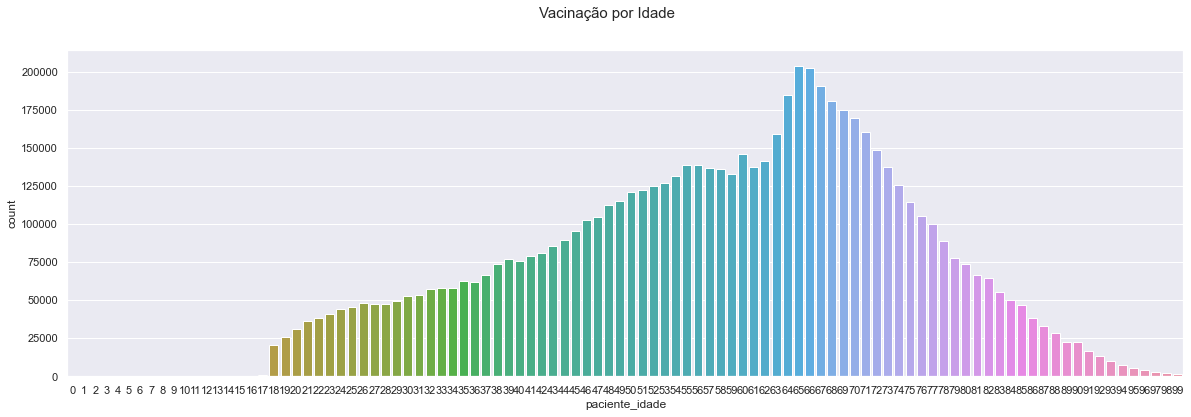

In [28]:
sns.set_theme(style='darkgrid')
fig, axes = plt.subplots(1, 1, figsize = (20,6))
sns.set_palette(palette)

sns.countplot(x='paciente_idade', data=vacinacao_rs[vacinacao_rs['paciente_idade'] < 100])

fig.suptitle('Vacinação por Idade', fontsize=15)

plt.show()

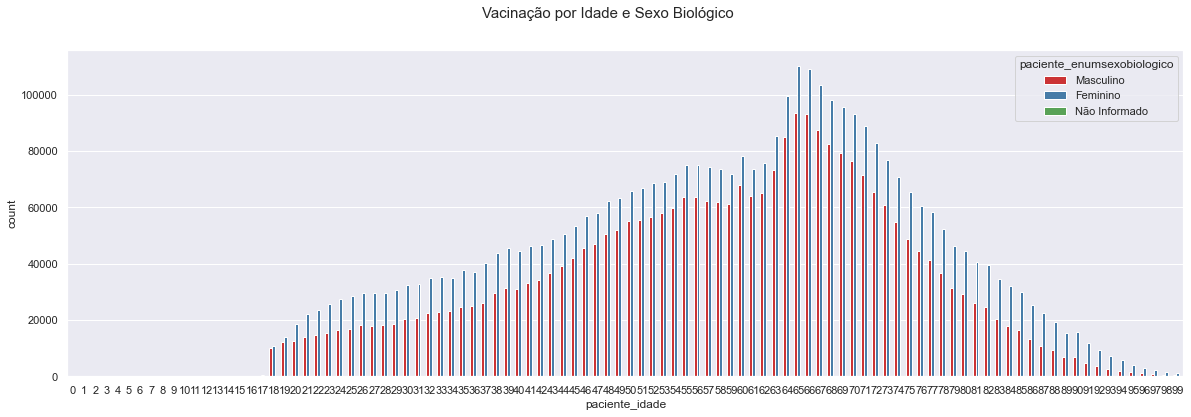

In [29]:
sns.set_theme(style='darkgrid')
fig, axes = plt.subplots(1, 1, figsize = (20,6))
sns.set_palette(palette)

sns.countplot(x='paciente_idade', hue='paciente_enumsexobiologico', data=vacinacao_rs[vacinacao_rs['paciente_idade'] < 100])

fig.suptitle('Vacinação por Idade e Sexo Biológico', fontsize=15)

plt.show()

In [30]:
vacinacao_rs['vacina_descricao_dose_int'] = np.where(vacinacao_rs['vacina_descricao_dose'].str.find('1') == -1 , 2, 1)
#vacinacao_rs['vacina_dataaplicacao'] = dateutil.parser.parse(vacinacao_rs['vacina_dataaplicacao'], dayfirst=True)

In [31]:
vacinacao_rs_dose_por_faixa_etaria_df = pd.DataFrame(np.array(faixa_etaria_rs_adultos), columns=['Faixa_Etaria_RS'])

In [32]:
vacinacao_rs_dose_por_faixa_etaria_df['primeira_dose'] = 0 
vacinacao_rs_dose_por_faixa_etaria_df['segunda_dose'] = 0 
vacinacao_rs_dose_por_faixa_etaria_df['primeira_dose_masculino'] = 0 
vacinacao_rs_dose_por_faixa_etaria_df['primeira_dose_feminino'] = 0 
vacinacao_rs_dose_por_faixa_etaria_df['segunda_dose_masculino'] = 0 
vacinacao_rs_dose_por_faixa_etaria_df['segunda_dose_feminino'] = 0 
vacinacao_rs_dose_por_faixa_etaria_df['populacao_2021'] = 0
vacinacao_rs_dose_por_faixa_etaria_df['populacao_2021_masculino'] = 0
vacinacao_rs_dose_por_faixa_etaria_df['populacao_2021_feminino'] = 0

In [33]:
pd.set_option('mode.chained_assignment', None) 

for faixa in faixa_etaria_rs_adultos:

    df = vacinacao_rs[(vacinacao_rs['faixa_etaria']==faixa) & (vacinacao_rs['vacina_descricao_dose_int']==1)]

    if not df.empty:
       vacinacao_rs_dose_por_faixa_etaria_df['primeira_dose'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] = len(df)
    else:     
       vacinacao_rs_dose_por_faixa_etaria_df['primeira_dose'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] = 0

    df = vacinacao_rs[(vacinacao_rs['faixa_etaria']==faixa) & (vacinacao_rs['vacina_descricao_dose_int']==1) & (vacinacao_rs['paciente_enumsexobiologico'] == 'Masculino')]

    if not df.empty:
       vacinacao_rs_dose_por_faixa_etaria_df['primeira_dose_masculino'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] = len(df) 
    else:     
       vacinacao_rs_dose_por_faixa_etaria_df['primeira_dose_masculino'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] = 0            

    df = vacinacao_rs[(vacinacao_rs['faixa_etaria']==faixa) & (vacinacao_rs['vacina_descricao_dose_int']==1) & (vacinacao_rs['paciente_enumsexobiologico'] == 'Feminino')]

    if not df.empty:
       vacinacao_rs_dose_por_faixa_etaria_df['primeira_dose_feminino'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] = len(df)
    else: 
       vacinacao_rs_dose_por_faixa_etaria_df['primeira_dose_feminino'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] = 0

    df = vacinacao_rs[(vacinacao_rs['faixa_etaria']==faixa) & (vacinacao_rs['vacina_descricao_dose_int']!=1)]
    
    if not df.empty:
        vacinacao_rs_dose_por_faixa_etaria_df['segunda_dose'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] = len(df)
    else:
        vacinacao_rs_dose_por_faixa_etaria_df['segunda_dose'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] = 0

    df = vacinacao_rs[(vacinacao_rs['faixa_etaria']==faixa) & (vacinacao_rs['vacina_descricao_dose_int']!=1) & (vacinacao_rs['paciente_enumsexobiologico'] == 'Masculino')]

    if not df.empty:
        vacinacao_rs_dose_por_faixa_etaria_df['segunda_dose_masculino'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] = len(df)
    else:
        vacinacao_rs_dose_por_faixa_etaria_df['segunda_dose_masculino'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] = 0
        
    df = vacinacao_rs[(vacinacao_rs['faixa_etaria']==faixa) & (vacinacao_rs['vacina_descricao_dose_int']!=1) & (vacinacao_rs['paciente_enumsexobiologico'] == 'Feminino')]

    if not df.empty:
        vacinacao_rs_dose_por_faixa_etaria_df['segunda_dose_feminino'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] =len(df)
    else:
        vacinacao_rs_dose_por_faixa_etaria_df['segunda_dose_feminino'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] = 0

    df = ibge_projecao_populacao[(ibge_projecao_populacao['Tipo'] == 'Geral') & (ibge_projecao_populacao['Faixa_Etaria_RS'] == faixa)]['2021'].sum()

    vacinacao_rs_dose_por_faixa_etaria_df['populacao_2021'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] = int(df)

    df = ibge_projecao_populacao[(ibge_projecao_populacao['Tipo'] == 'Masculino') & (ibge_projecao_populacao['Faixa_Etaria_RS'] == faixa)]['2021'].sum()

    vacinacao_rs_dose_por_faixa_etaria_df['populacao_2021_masculino'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] = int(df)
        
    df = ibge_projecao_populacao[(ibge_projecao_populacao['Tipo'] == 'Feminino') & (ibge_projecao_populacao['Faixa_Etaria_RS'] == faixa)]['2021'].sum()

    vacinacao_rs_dose_por_faixa_etaria_df['populacao_2021_feminino'].loc[vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'] == faixa] = int(df)



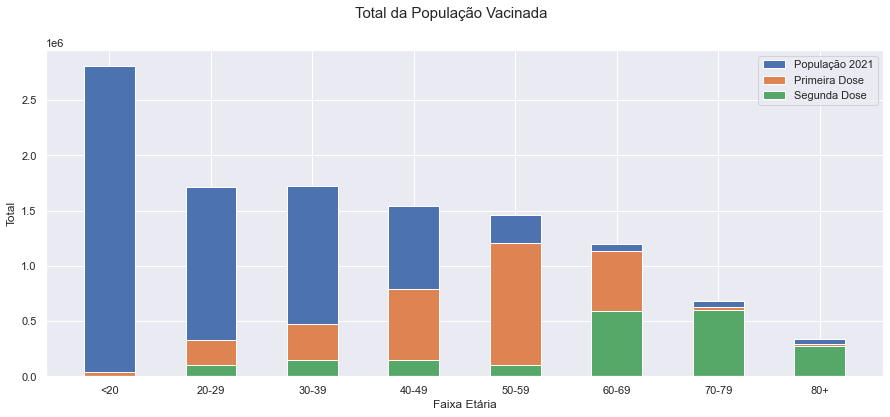

In [34]:
sns.set_theme(style='darkgrid')
fig, axes = plt.subplots(1, 1, figsize = (15,6))
sns.set_palette(palette)

x = vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS']
y1 = vacinacao_rs_dose_por_faixa_etaria_df['populacao_2021']
y2 = vacinacao_rs_dose_por_faixa_etaria_df['primeira_dose']
y3 = vacinacao_rs_dose_por_faixa_etaria_df['segunda_dose']
width = 0.5
  
# plot data in grouped manner of bar type
plt.bar(x, y1, width)
plt.bar(x, y2, width)
plt.bar(x, y3, width)
plt.xticks(x, faixa_etaria_rs_adultos)
plt.xlabel("Faixa Etária")
plt.ylabel("Total")
plt.legend(["População 2021", "Primeira Dose", "Segunda Dose"])
fig.suptitle('Total da População Vacinada', fontsize=15)
plt.show()

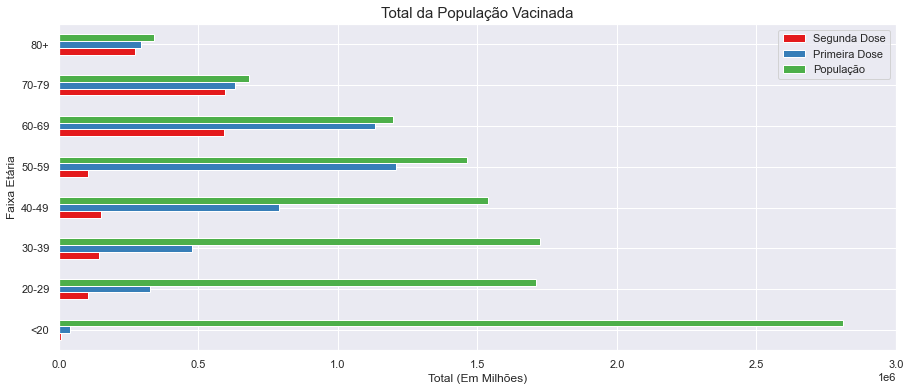

In [35]:
sns.set_palette(palette)

x = vacinacao_rs_dose_por_faixa_etaria_df['Faixa_Etaria_RS'].values
y1 = vacinacao_rs_dose_por_faixa_etaria_df['populacao_2021'].values
y2 = vacinacao_rs_dose_por_faixa_etaria_df['primeira_dose'].values
y3 = vacinacao_rs_dose_por_faixa_etaria_df['segunda_dose'].values

plotdata = pd.DataFrame({
    "segunda_dose":y3,
    "primeira_dose":y2,
    "populacao_2021":y1}, 
    index=x
)

plotdata.plot(kind="barh",  figsize = (15,6))

plt.title('Total da População Vacinada', fontsize=15)
plt.legend(['Segunda Dose', 'Primeira Dose', 'População'])
plt.xlabel("Total (Em Milhões)")
plt.ylabel("Faixa Etária")

plt.xlim(0, 3000000)

plt.savefig('Total_Populacao_Vacinada.png', dpi=300)

# Casos de Covid

In [36]:
casos_de_covid_rw = pd.read_table('Casos_Covid_RS_20210703.csv', delimiter=';')

In [37]:
casos_de_covid_rw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230115 entries, 0 to 1230114
Data columns (total 30 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   COD_IBGE                1230115 non-null  int64 
 1   MUNICIPIO               1230115 non-null  object
 2   COD_REGIAO_COVID        1230115 non-null  int64 
 3   REGIAO_COVID            1230115 non-null  object
 4   SEXO                    1230115 non-null  object
 5   FAIXAETARIA             1230115 non-null  object
 6   CRITERIO                1230115 non-null  object
 7   DATA_CONFIRMACAO        1230115 non-null  object
 8   DATA_SINTOMAS           1230115 non-null  object
 9   DATA_INCLUSAO           1230115 non-null  object
 10  DATA_EVOLUCAO           87546 non-null    object
 11  EVOLUCAO                1230115 non-null  object
 12  HOSPITALIZADO           1230115 non-null  object
 13  FEBRE                   1230095 non-null  object
 14  TOSSE             

In [38]:
casos_de_covid_rw.groupby(['FAIXAETARIA']).size()

FAIXAETARIA
01 a 04       16092
05 a 09       19567
10 a 14       26055
15 a 19       56687
20 a 29      228178
30 a 39      266352
40 a 49      224466
50 a 59      186332
60 a 69      116042
70 a 79       55739
80 e mais     27426
<1             7179
dtype: int64

In [39]:
casos_de_covid_rw.head(100)

,COD_IBGE,MUNICIPIO,COD_REGIAO_COVID,REGIAO_COVID,SEXO,FAIXAETARIA,CRITERIO,DATA_CONFIRMACAO,DATA_SINTOMAS,DATA_INCLUSAO,...,DATA_INCLUSAO_OBITO,DATA_EVOLUCAO_ESTIMADA,RACA_COR,ETNIA_INDIGENA,PROFISSIONAL_SAUDE,BAIRRO,SRAG,FONTE_INFORMACAO,PAIS_NASCIMENTO,PES_PRIV_LIBERDADE
0,430003,ACEGUÁ,16,BAGE - R22,Masculino,40 a 49,TESTE RÁPIDO,06/04/2021,06/04/2021,05/05/2021,...,NaN,20/04/2021,BRANCA,NAO ENCONTRADO,NAO,CENTRO,NAO,E-SUS,BRASIL,NAO
1,430003,ACEGUÁ,16,BAGE - R22,Feminino,70 a 79,TESTE RÁPIDO,31/03/2021,31/03/2021,05/05/2021,...,NaN,14/04/2021,BRANCA,NaN,NAO,CENTRO,NAO,E-SUS,NaN,NAO
2,430003,ACEGUÁ,16,BAGE - R22,Masculino,40 a 49,TESTE RÁPIDO,06/04/2021,02/04/2021,08/04/2021,...,NaN,16/04/2021,BRANCA,NAO ENCONTRADO,NAO,INTERIOR,NAO,E-SUS,BRASIL,NAO
3,430003,ACEGUÁ,16,BAGE - R22,Masculino,70 a 79,RT-PCR,05/04/2021,01/04/2021,14/04/2021,...,NaN,15/04/2021,BRANCA,NAO ENCONTRADO,NAO,CENTRO,NAO,E-SUS,BRASIL,NAO
4,430003,ACEGUÁ,16,BAGE - R22,Feminino,30 a 39,TESTE RÁPIDO,22/03/2021,18/03/2021,07/04/2021,...,NaN,01/04/2021,BRANCA,NAO ENCONTRADO,NAO,'COLONIA NOVA,NAO,E-SUS,BRASIL,NAO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,430003,ACEGUÁ,16,BAGE - R22,Feminino,15 a 19,TESTE RÁPIDO,01/04/2021,29/03/2021,08/04/2021,...,NaN,12/04/2021,BRANCA,NAO ENCONTRADO,NAO,BELA VISTA,NAO,E-SUS,BRASIL,NAO
96,430003,ACEGUÁ,16,BAGE - R22,Feminino,50 a 59,TESTE RÁPIDO,29/03/2021,24/03/2021,08/04/2021,...,NaN,NaN,PARDA,NAO ENCONTRADO,NAO INFORMADO,NAO INFORMADO,SIM,SIVEP HOSP,BRASIL,NAO
97,430003,ACEGUÁ,16,BAGE - R22,Feminino,15 a 19,TESTE RÁPIDO,01/04/2021,29/03/2021,08/04/2021,...,NaN,12/04/2021,BRANCA,NAO ENCONTRADO,NAO,BELA VISTA,NAO,E-SUS,BRASIL,NAO
98,430003,ACEGUÁ,16,BAGE - R22,Masculino,30 a 39,RT-PCR,08/03/2021,06/03/2021,16/03/2021,...,NaN,20/03/2021,BRANCA,NAO ENCONTRADO,NAO,INTERIOR,NAO,E-SUS,BRASIL,NAO


Prepara o data para processamento, convertendo as datas para o formato do projeto. 

In [40]:
casos_de_covid_rw['DATA_CONFIRMACAO'] = casos_de_covid_rw['DATA_CONFIRMACAO'].apply(dateutil.parser.parse, dayfirst=True)

In [41]:
for ind in casos_de_covid_rw.index:
    if isinstance(casos_de_covid_rw['DATA_INCLUSAO_OBITO'][ind],str):
       casos_de_covid_rw['DATA_INCLUSAO_OBITO'][ind] = dateutil.parser.parse(casos_de_covid_rw['DATA_INCLUSAO_OBITO'][ind], dayfirst=True )

In [42]:
casos_de_covid_rw['FAIXAETARIA_RS'] = ''
casos_de_covid_rw['FAIXAETARIA_RS'] = np.where(casos_de_covid_rw['FAIXAETARIA'] == '<1', '<20', casos_de_covid_rw['FAIXAETARIA_RS'])
casos_de_covid_rw['FAIXAETARIA_RS'] = np.where(casos_de_covid_rw['FAIXAETARIA'] == '01 a 04', '<20', casos_de_covid_rw['FAIXAETARIA_RS'])
casos_de_covid_rw['FAIXAETARIA_RS'] = np.where(casos_de_covid_rw['FAIXAETARIA'] == '05 a 09', '<20', casos_de_covid_rw['FAIXAETARIA_RS'])
casos_de_covid_rw['FAIXAETARIA_RS'] = np.where(casos_de_covid_rw['FAIXAETARIA'] == '10 a 14', '<20', casos_de_covid_rw['FAIXAETARIA_RS'])
casos_de_covid_rw['FAIXAETARIA_RS'] = np.where(casos_de_covid_rw['FAIXAETARIA'] == '15 a 19', '<20', casos_de_covid_rw['FAIXAETARIA_RS'])
casos_de_covid_rw['FAIXAETARIA_RS'] = np.where(casos_de_covid_rw['FAIXAETARIA'] == '20 a 29', '20-29', casos_de_covid_rw['FAIXAETARIA_RS'])
casos_de_covid_rw['FAIXAETARIA_RS'] = np.where(casos_de_covid_rw['FAIXAETARIA'] == '30 a 39', '30-39', casos_de_covid_rw['FAIXAETARIA_RS'])
casos_de_covid_rw['FAIXAETARIA_RS'] = np.where(casos_de_covid_rw['FAIXAETARIA'] == '40 a 49', '40-49', casos_de_covid_rw['FAIXAETARIA_RS'])
casos_de_covid_rw['FAIXAETARIA_RS'] = np.where(casos_de_covid_rw['FAIXAETARIA'] == '50 a 59', '50-59', casos_de_covid_rw['FAIXAETARIA_RS'])
casos_de_covid_rw['FAIXAETARIA_RS'] = np.where(casos_de_covid_rw['FAIXAETARIA'] == '60 a 69', '60-69', casos_de_covid_rw['FAIXAETARIA_RS'])
casos_de_covid_rw['FAIXAETARIA_RS'] = np.where(casos_de_covid_rw['FAIXAETARIA'] == '70 a 79', '70-79', casos_de_covid_rw['FAIXAETARIA_RS'])
casos_de_covid_rw['FAIXAETARIA_RS'] = np.where(casos_de_covid_rw['FAIXAETARIA'] == '80 e mais', '80+', casos_de_covid_rw['FAIXAETARIA_RS'])

In [43]:
casos_de_covid_rw.head(10)

,COD_IBGE,MUNICIPIO,COD_REGIAO_COVID,REGIAO_COVID,SEXO,FAIXAETARIA,CRITERIO,DATA_CONFIRMACAO,DATA_SINTOMAS,DATA_INCLUSAO,...,DATA_EVOLUCAO_ESTIMADA,RACA_COR,ETNIA_INDIGENA,PROFISSIONAL_SAUDE,BAIRRO,SRAG,FONTE_INFORMACAO,PAIS_NASCIMENTO,PES_PRIV_LIBERDADE,FAIXAETARIA_RS
0,430003,ACEGUÁ,16,BAGE - R22,Masculino,40 a 49,TESTE RÁPIDO,2021-04-06,06/04/2021,05/05/2021,...,20/04/2021,BRANCA,NAO ENCONTRADO,NAO,CENTRO,NAO,E-SUS,BRASIL,NAO,40-49
1,430003,ACEGUÁ,16,BAGE - R22,Feminino,70 a 79,TESTE RÁPIDO,2021-03-31,31/03/2021,05/05/2021,...,14/04/2021,BRANCA,NaN,NAO,CENTRO,NAO,E-SUS,NaN,NAO,70-79
2,430003,ACEGUÁ,16,BAGE - R22,Masculino,40 a 49,TESTE RÁPIDO,2021-04-06,02/04/2021,08/04/2021,...,16/04/2021,BRANCA,NAO ENCONTRADO,NAO,INTERIOR,NAO,E-SUS,BRASIL,NAO,40-49
3,430003,ACEGUÁ,16,BAGE - R22,Masculino,70 a 79,RT-PCR,2021-04-05,01/04/2021,14/04/2021,...,15/04/2021,BRANCA,NAO ENCONTRADO,NAO,CENTRO,NAO,E-SUS,BRASIL,NAO,70-79
4,430003,ACEGUÁ,16,BAGE - R22,Feminino,30 a 39,TESTE RÁPIDO,2021-03-22,18/03/2021,07/04/2021,...,01/04/2021,BRANCA,NAO ENCONTRADO,NAO,'COLONIA NOVA,NAO,E-SUS,BRASIL,NAO,30-39
5,430003,ACEGUÁ,16,BAGE - R22,Masculino,20 a 29,TESTE RÁPIDO,2021-03-20,18/03/2021,07/04/2021,...,01/04/2021,BRANCA,NAO ENCONTRADO,NAO,PORTEIRA PRETA,NAO,E-SUS,BRASIL,NAO,20-29
6,430003,ACEGUÁ,16,BAGE - R22,Feminino,20 a 29,TESTE RÁPIDO,2021-04-01,25/03/2021,07/04/2021,...,08/04/2021,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO,20-29
7,430003,ACEGUÁ,16,BAGE - R22,Feminino,50 a 59,RT-PCR,2021-03-29,29/03/2021,07/04/2021,...,12/04/2021,PRETA,NAO ENCONTRADO,NAO,INTERIOR,NAO,E-SUS,BRASIL,NAO,50-59
8,430003,ACEGUÁ,16,BAGE - R22,Feminino,50 a 59,TESTE RÁPIDO,2021-04-05,29/03/2021,08/04/2021,...,12/04/2021,BRANCA,NAO ENCONTRADO,NAO,INTERIOR,NAO,E-SUS,BRASIL,NAO,50-59
9,430003,ACEGUÁ,16,BAGE - R22,Masculino,50 a 59,TESTE RÁPIDO,2021-04-09,27/03/2021,13/04/2021,...,NaN,BRANCA,NAO ENCONTRADO,NAO INFORMADO,RURAL,SIM,SIVEP HOSP,BRASIL,NAO,50-59


In [44]:
 casos_de_covid_total = casos_de_covid_rw.groupby('DATA_CONFIRMACAO', as_index=False).agg(TOTAL=pd.NamedAgg(column='DATA_CONFIRMACAO', aggfunc=len))
 casos_de_covid_total.sort_values(by=['DATA_CONFIRMACAO'], inplace=True)

In [45]:
casos_de_covid_total['MEDIA_MOVEL_7'] = casos_de_covid_total["TOTAL"].rolling(7).mean()

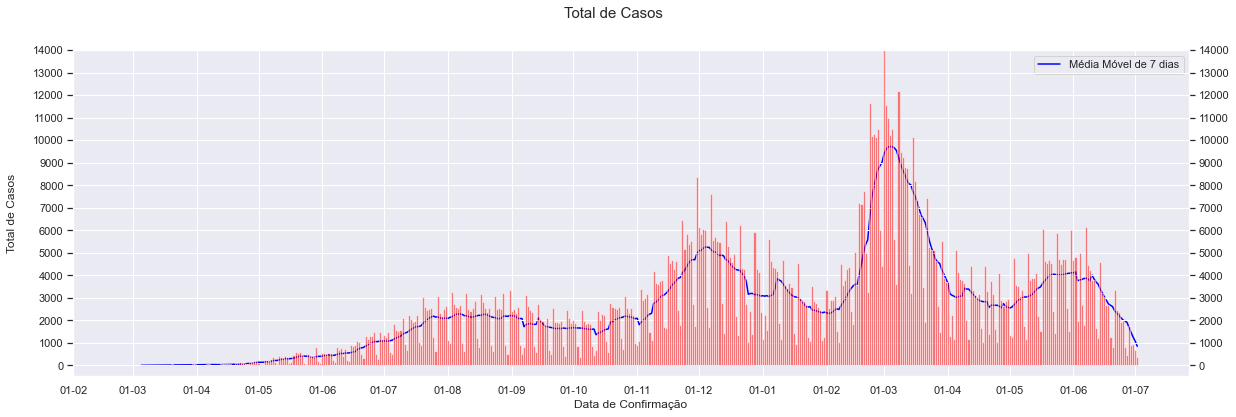

In [81]:
sns.set_theme(style='darkgrid')
fig, ax1 = plt.subplots(1, 1, figsize = (20,6))
sns.set_palette(palette)

ax2 = ax1.twinx()  

ax1.plot(casos_de_covid_total.DATA_CONFIRMACAO, casos_de_covid_total.MEDIA_MOVEL_7, color='blue', label='Média Móvel de 7 dias') 

ax2.bar(casos_de_covid_total.DATA_CONFIRMACAO, casos_de_covid_total.TOTAL, width=1, color='red', alpha=0.5)

date_form = mdates.DateFormatter('%d-%m')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(date_form)

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

ax1.set_yticks( range(0, 15000, 1000) )
ax2.set_yticks( range(0, 15000, 1000) )

ax1.yaxis.set_label_coords(-0.05, 0.5)

ax2.set_ylim(ax1.get_ylim())

fig.suptitle('Total de Casos', fontsize=15)

ax1.legend()

ax1.set_xlabel('Data de Confirmação', fontsize=12)
ax1.set_ylabel('Total de Casos', fontsize=12)

plt.savefig('Total_de_Casos.png', dpi=300)

plt.show()

# Óbitos

In [47]:
obitos_de_covid_total = casos_de_covid_rw.groupby('DATA_INCLUSAO_OBITO', as_index=False).agg(TOTAL=pd.NamedAgg(column='DATA_INCLUSAO_OBITO', aggfunc=len))
obitos_de_covid_total.sort_values(by=['DATA_INCLUSAO_OBITO'], inplace=True)
obitos_de_covid_total['MEDIA_MOVEL_7'] = obitos_de_covid_total["TOTAL"].rolling(7).mean()
obitos_de_covid_total['MEDIA_MOVEL_14'] = obitos_de_covid_total["TOTAL"].rolling(14).mean()
obitos_de_covid_total.head(100)

,DATA_INCLUSAO_OBITO,TOTAL,MEDIA_MOVEL_7,MEDIA_MOVEL_14
0,2020-03-24,1,NaN,NaN
1,2020-03-26,1,NaN,NaN
2,2020-03-28,1,NaN,NaN
3,2020-03-30,1,NaN,NaN
4,2020-04-01,1,NaN,NaN
...,...,...,...,...
95,2020-07-07,34,25.571429,24.000000
96,2020-07-08,32,27.000000,24.928571
97,2020-07-09,45,29.571429,26.428571
98,2020-07-10,49,32.714286,27.071429


In [48]:
obitos_de_covid_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 0 to 455
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATA_INCLUSAO_OBITO  456 non-null    datetime64[ns]
 1   TOTAL                456 non-null    int64         
 2   MEDIA_MOVEL_7        450 non-null    float64       
 3   MEDIA_MOVEL_14       443 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 17.8 KB


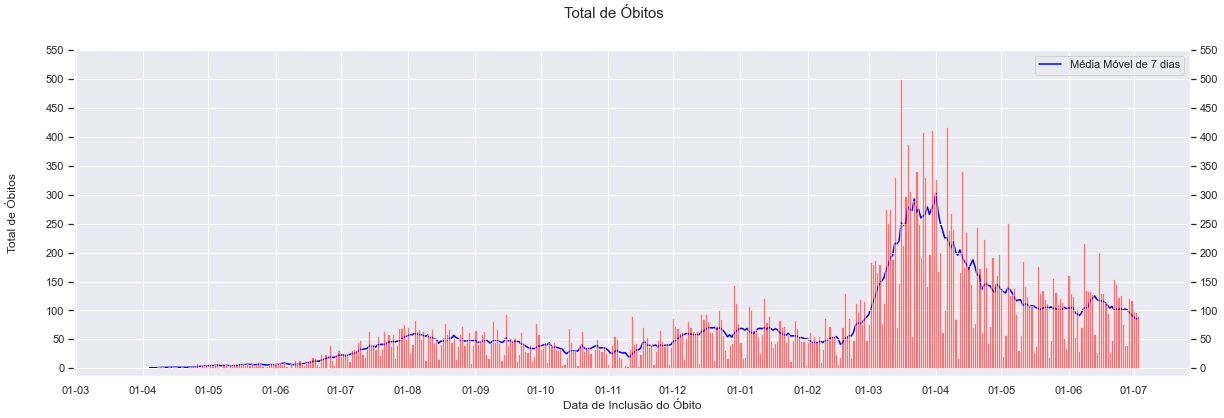

In [82]:
sns.set_theme(style='darkgrid')
fig, ax1 = plt.subplots(1, 1, figsize = (20,6))
sns.set_palette(palette)

ax2 = ax1.twinx()  

ax1.plot(obitos_de_covid_total.DATA_INCLUSAO_OBITO, obitos_de_covid_total.MEDIA_MOVEL_7, color='blue', label='Média Móvel de 7 dias') 

ax2.bar(obitos_de_covid_total.DATA_INCLUSAO_OBITO, obitos_de_covid_total.TOTAL, width=1, color='red', alpha=0.5)

date_form = mdates.DateFormatter('%d-%m')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(date_form)

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

ax1.set_yticks( range(0, 600, 50) )
ax2.set_yticks( range(0, 600, 50) )

ax1.yaxis.set_label_coords(-0.05, 0.5)

ax2.set_ylim(ax1.get_ylim())

ax1.set_xlabel('Data de Inclusão do Óbito', fontsize=12)
ax1.set_ylabel('Total de Óbitos', fontsize=12)

fig.suptitle('Total de Óbitos', fontsize=15)

ax1.legend()

plt.savefig('Total_de_Obitos.png', dpi=300)

plt.show()

# Resultados

In [50]:
data_primeiro_caso = casos_de_covid_rw['DATA_CONFIRMACAO'].min()
data_primeiro_obito = casos_de_covid_rw[casos_de_covid_rw['DATA_INCLUSAO_OBITO'] > data_primeiro_caso]['DATA_INCLUSAO_OBITO'].min()

In [51]:
print(data_primeiro_caso)
print(data_primeiro_obito)

2020-02-26 00:00:00
2020-03-24 00:00:00


In [52]:
casos_de_covid_total_faixa_etaria = casos_de_covid_rw.groupby(['FAIXAETARIA_RS'], as_index=False).agg(TOTAL=pd.NamedAgg(column='FAIXAETARIA_RS', aggfunc=len))
casos_de_covid_total_faixa_etaria.sort_values(by=['FAIXAETARIA_RS'], inplace=True)
casos_de_covid_total_faixa_etaria.head(100)

,FAIXAETARIA_RS,TOTAL
0,20-29,228178
1,30-39,266352
2,40-49,224466
3,50-59,186332
4,60-69,116042
5,70-79,55739
6,80+,27426
7,<20,125580


In [53]:
data = casos_de_covid_rw['DATA_CONFIRMACAO'].min()
obitos_de_covid_total_faixa_etaria = casos_de_covid_rw[casos_de_covid_rw['DATA_INCLUSAO_OBITO'] > data].groupby(['FAIXAETARIA_RS'], as_index=False).agg(TOTAL=pd.NamedAgg(column='FAIXAETARIA_RS', aggfunc=len))
obitos_de_covid_total_faixa_etaria.head(1000)

,FAIXAETARIA_RS,TOTAL
0,20-29,341
1,30-39,1181
2,40-49,2591
3,50-59,4883
4,60-69,7729
5,70-79,8016
6,80+,6882
7,<20,66


In [54]:
casos_de_covid_dia_faixa_etaria = casos_de_covid_rw.groupby(['DATA_CONFIRMACAO', 'FAIXAETARIA_RS'], as_index=False).agg(TOTAL=pd.NamedAgg(column='FAIXAETARIA_RS', aggfunc=len))
casos_de_covid_dia_faixa_etaria.sort_values(by=['DATA_CONFIRMACAO', 'FAIXAETARIA_RS'], inplace=True)
casos_de_covid_dia_faixa_etaria.head(100)

,DATA_CONFIRMACAO,FAIXAETARIA_RS,TOTAL
0,2020-02-26,30-39,1
1,2020-02-29,40-49,1
2,2020-03-01,40-49,1
3,2020-03-01,50-59,2
4,2020-03-01,60-69,2
...,...,...,...
95,2020-03-20,<20,2
96,2020-03-21,20-29,1
97,2020-03-21,30-39,2
98,2020-03-21,40-49,1


In [55]:
obitos_de_covid_dia_faixa_etaria = casos_de_covid_rw.groupby(['DATA_INCLUSAO_OBITO', 'FAIXAETARIA_RS'], as_index=False).agg(TOTAL=pd.NamedAgg(column='FAIXAETARIA_RS', aggfunc=len))
obitos_de_covid_dia_faixa_etaria.sort_values(by=['DATA_INCLUSAO_OBITO', 'FAIXAETARIA_RS'], inplace=True)
obitos_de_covid_dia_faixa_etaria.head(10000)

,DATA_INCLUSAO_OBITO,FAIXAETARIA_RS,TOTAL
0,2020-03-24,80+,1
1,2020-03-26,80+,1
2,2020-03-28,80+,1
3,2020-03-30,60-69,1
4,2020-04-01,50-59,1
...,...,...,...
2524,2021-07-03,40-49,12
2525,2021-07-03,50-59,17
2526,2021-07-03,60-69,14
2527,2021-07-03,70-79,21


In [56]:
vacinacao_rs_total = vacinacao_rs.groupby(['vacina_dataaplicacao', 'vacina_descricao_dose_int'], as_index=False).agg(TOTAL=pd.NamedAgg(column='vacina_dataaplicacao', aggfunc=len))
vacinacao_rs_total.sort_values(by=['vacina_dataaplicacao', 'vacina_descricao_dose_int'], inplace=True)
vacinacao_rs_total['vacina_dataaplicacao'] = vacinacao_rs_total['vacina_dataaplicacao'].apply(dateutil.parser.parse, dayfirst=True)
vacinacao_rs_total.head(100)

,vacina_dataaplicacao,vacina_descricao_dose_int,TOTAL
0,1956-05-04,1,1
1,1964-09-18,1,1
2,2021-10-01,1,1
3,2021-12-01,2,1
4,2021-01-14,1,9
...,...,...,...
95,2021-04-03,1,12603
96,2021-04-03,2,7411
97,2021-05-03,1,12480
98,2021-05-03,2,11174


In [57]:
vacinacao_rs_total_por_faixa_etaria = vacinacao_rs.groupby(['vacina_dataaplicacao', 'faixa_etaria', 'vacina_descricao_dose_int'], as_index=False).agg(TOTAL=pd.NamedAgg(column='vacina_dataaplicacao', aggfunc=len))
vacinacao_rs_total_por_faixa_etaria.sort_values(by=['vacina_dataaplicacao', 'faixa_etaria', 'vacina_descricao_dose_int'], inplace=True)
vacinacao_rs_total_por_faixa_etaria['vacina_dataaplicacao'] = vacinacao_rs_total_por_faixa_etaria['vacina_dataaplicacao'].apply(dateutil.parser.parse, dayfirst=True)
vacinacao_rs_total_por_faixa_etaria.head(100)

,vacina_dataaplicacao,faixa_etaria,vacina_descricao_dose_int,TOTAL
0,1956-05-04,<20,1,1
1,1964-09-18,<20,1,1
2,2021-10-01,60-69,1,1
3,2021-12-01,50-59,2,1
4,2021-01-14,60-69,1,9
...,...,...,...,...
95,2021-01-23,80+,2,2
96,2021-01-23,<20,1,19
97,2021-01-24,20-29,1,49
98,2021-01-24,30-39,1,90


In [58]:
casos_de_covid_total_resultado = casos_de_covid_total.copy(deep=True)
casos_de_covid_total_resultado['TOTAL_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_OBITOS'] = 0
casos_de_covid_total_resultado['TOTAL_OBITOS_ACUMULADO'] = 0
casos_de_covid_total_resultado['OBITOS_MEDIA_MOVEL_7'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_60'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_60_ACUMULADO'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_60'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_70'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_70_ACUMULADO'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_70'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_<20'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_<20_ACUMULADO'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_20_29'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_20_29_ACUMULADO'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_30_39'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_30_39_ACUMULADO'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_40_49'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_40_49_ACUMULADO'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_50_59'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_50_59_ACUMULADO'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_60_69'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_60_69_ACUMULADO'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_70_79'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_70_79_ACUMULADO'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_80+'] = 0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_80+_ACUMULADO'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_60'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_60_ACUMULADO'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_60'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_70'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_70_ACUMULADO'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_70'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_<20'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_<20_ACUMULADO'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_20_29'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_20_29_ACUMULADO'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_30_39'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_30_39_ACUMULADO'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_40_49'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_40_49_ACUMULADO'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_50_59'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_50_59_ACUMULADO'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_60_69'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_60_69_ACUMULADO'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_70_79'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_70_79_ACUMULADO'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_80+'] = 0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_80+_ACUMULADO'] = 0

casos_de_covid_total_resultado.head(10)


,DATA_CONFIRMACAO,TOTAL,MEDIA_MOVEL_7,TOTAL_ACUMULADO,TOTAL_OBITOS,TOTAL_OBITOS_ACUMULADO,OBITOS_MEDIA_MOVEL_7,CASOS_FAIXA_ETARIA_MENOR_60,CASOS_FAIXA_ETARIA_MENOR_60_ACUMULADO,CASOS_FAIXA_ETARIA_MAIOR_60,...,OBITOS_FAIXA_ETARIA_40_49,OBITOS_FAIXA_ETARIA_40_49_ACUMULADO,OBITOS_FAIXA_ETARIA_50_59,OBITOS_FAIXA_ETARIA_50_59_ACUMULADO,OBITOS_FAIXA_ETARIA_60_69,OBITOS_FAIXA_ETARIA_60_69_ACUMULADO,OBITOS_FAIXA_ETARIA_70_79,OBITOS_FAIXA_ETARIA_70_79_ACUMULADO,OBITOS_FAIXA_ETARIA_80+,OBITOS_FAIXA_ETARIA_80+_ACUMULADO
0,2020-02-26,1,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-02-29,1,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-03-01,8,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-03-02,4,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-03-03,3,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2020-03-04,5,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2020-03-05,8,4.285714,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2020-03-06,5,4.857143,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2020-03-08,3,5.142857,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2020-03-09,10,5.428571,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
primeiro_registro = True

total_acumulado = 0
total_acumulado_obitos = 0
total_casos_60_menos = 0
total_casos_60_mais = 0
total_obitos_60_menos = 0
total_obitos_60_mais = 0
total_casos_70_menos = 0
total_casos_70_mais = 0
total_obitos_70_menos = 0
total_obitos_70_mais = 0


for ind in casos_de_covid_total_resultado.index:
    
    data_confirmacao = casos_de_covid_total_resultado['DATA_CONFIRMACAO'][ind]

    if not primeiro_registro:
        total_acumulado += casos_de_covid_total_resultado['TOTAL'][ind]

    casos_de_covid_total_resultado['TOTAL_ACUMULADO'][ind] = total_acumulado    

    for faixa in faixa_etaria_rs_adultos:
        df = casos_de_covid_dia_faixa_etaria[(casos_de_covid_dia_faixa_etaria['DATA_CONFIRMACAO'] == data_confirmacao) & (casos_de_covid_dia_faixa_etaria['FAIXAETARIA_RS'] == faixa)]['TOTAL']

        if not df.empty:
            casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_' + faixa.replace('-', '_')][ind] = int(df)               
        else:     
            casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_' + faixa.replace('-', '_')][ind] = 0

    casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_60'][ind] = int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_<20'][ind]) + int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_20_29'][ind]) +                                                                          int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_30_39'][ind]) + int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_40_49'][ind]) +                                                                         int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_50_59'][ind]) 

    if not primeiro_registro:
        total_casos_60_menos += casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_60'][ind]  

    casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_60_ACUMULADO'][ind] = total_casos_60_menos      

    casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_70'][ind] = int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_<20'][ind]) + int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_20_29'][ind]) +                                                                          int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_30_39'][ind]) + int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_40_49'][ind]) +                                                                         int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_50_59'][ind]) + int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_60_69'][ind])

    if not primeiro_registro:
        total_casos_70_menos += casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_70'][ind]  

    casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_70_ACUMULADO'][ind] = total_casos_70_menos              

    casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_60'][ind] = int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_60_69'][ind]) +                                                                      int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_70_79'][ind]) + int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_80+'][ind]) 

    if not primeiro_registro:
        total_casos_60_mais += casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_60'][ind]  

    casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO'][ind] = total_casos_60_mais

    casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_70'][ind] = int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_70_79'][ind]) + int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_80+'][ind]) 

    if not primeiro_registro:
        total_casos_70_mais += casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_70'][ind]  

    casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO'][ind] = total_casos_70_mais

    # Obitos
    for faixa in faixa_etaria_rs_adultos:
        df = obitos_de_covid_dia_faixa_etaria[(obitos_de_covid_dia_faixa_etaria['DATA_INCLUSAO_OBITO'] == data_confirmacao) & (obitos_de_covid_dia_faixa_etaria['FAIXAETARIA_RS'] == faixa)]['TOTAL']

        if not df.empty:
            casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_' + faixa.replace('-', '_')][ind] = int(df)               
        else:     
            casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_' + faixa.replace('-', '_')][ind] = 0

    casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_60'][ind] = int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_<20'][ind]) + int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_20_29'][ind]) +                                                                          int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_30_39'][ind]) + int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_40_49'][ind]) +                                                                         int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_50_59'][ind]) 

    if not primeiro_registro:
        total_obitos_60_menos += casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_60'][ind]  

    casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_60_ACUMULADO'][ind] = total_obitos_60_menos         

    casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_70'][ind] = int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_<20'][ind]) + int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_20_29'][ind]) +                                                                          int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_30_39'][ind]) + int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_40_49'][ind]) +                                                                         int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_50_59'][ind]) + int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_60_69'][ind]) 

    if not primeiro_registro:
        total_obitos_70_menos += casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_70'][ind]  

    casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_70_ACUMULADO'][ind] = total_obitos_70_menos 

    casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_60'][ind] = int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_60_69'][ind]) +                                                                          int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_70_79'][ind]) + int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_80+'][ind]) 

    if not primeiro_registro:
        total_obitos_60_mais += casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_60'][ind]  

    casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO'][ind] = total_obitos_60_mais         

    casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_70'][ind] = int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_70_79'][ind]) + int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_80+'][ind]) 

    if not primeiro_registro:
        total_obitos_70_mais += casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_70'][ind]  

    casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO'][ind] = total_obitos_70_mais 


    primeiro_registro = False

primeiro_registro = True

for ind in casos_de_covid_total_resultado.index:
   data_confirmacao = casos_de_covid_total_resultado['DATA_CONFIRMACAO'][ind]

   # Total de Óbitos
   df = obitos_de_covid_total[obitos_de_covid_total['DATA_INCLUSAO_OBITO'] == data_confirmacao]['TOTAL'] 
   if not df.empty:
       casos_de_covid_total_resultado['TOTAL_OBITOS'][ind] = int(df)

   if not primeiro_registro:
        total_acumulado_obitos += casos_de_covid_total_resultado['TOTAL_OBITOS'][ind]

   casos_de_covid_total_resultado['TOTAL_OBITOS_ACUMULADO'][ind] = total_acumulado_obitos           

   # Média Móvel de Óbitos
   df = obitos_de_covid_total[obitos_de_covid_total['DATA_INCLUSAO_OBITO'] == data_confirmacao]['MEDIA_MOVEL_7'] 
   if not df.empty:
        casos_de_covid_total_resultado['OBITOS_MEDIA_MOVEL_7'][ind] = float(df)
    
   primeiro_registro = False

In [60]:
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_NO_DIA'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_<20'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_<20_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_20_29'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_20_29_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_30_39'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_30_39_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_40_49'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_40_49_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_50_59'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_50_59_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_60_69'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_60_69_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_70_79'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_70_79_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_80+'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_80+_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_NO_DIA'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_<20'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_<20_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_20_29'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_20_29_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_30_39'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_30_39_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_40_49'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_40_49_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_50_59'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_50_59_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_60_69'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_60_69_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_70_79'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_70_79_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_80+'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_80+_ACUMULADO'] = 0

casos_de_covid_total_resultado['TOTAL_VACINADOS_1_MENOR_60'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_MENOR_60_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_MAIOR_60'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_MAIOR_60_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_MENOR_70'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_MENOR_70_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_MAIOR_70'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_1_MAIOR_70_ACUMULADO'] = 0

casos_de_covid_total_resultado['TOTAL_VACINADOS_2_MENOR_60'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_MENOR_60_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_MAIOR_60'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_MAIOR_60_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_MENOR_70'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_MENOR_70_ACUMULADO'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_MAIOR_70'] = 0
casos_de_covid_total_resultado['TOTAL_VACINADOS_2_MAIOR_70_ACUMULADO'] = 0

In [61]:
primeiro_registro = True
total_vacinado_1_dose = 0
total_vacinado_2_dose = 0

for ind in casos_de_covid_total_resultado.index:
    
    data_confirmacao = casos_de_covid_total_resultado['DATA_CONFIRMACAO'][ind]

    # Primeira dose
    df = vacinacao_rs_total[(vacinacao_rs_total['vacina_dataaplicacao'] == data_confirmacao) & (vacinacao_rs_total['vacina_descricao_dose_int'] == 1) ]['TOTAL']

    if not df.empty:
        casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_NO_DIA'][ind] = int(df)               
    else:     
        casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_NO_DIA'][ind] = 0

    if not primeiro_registro:
        total_vacinado_1_dose += casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_NO_DIA'][ind]

    casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_ACUMULADO'][ind] = total_vacinado_1_dose

    for faixa in faixa_etaria_rs_adultos:
        df = vacinacao_rs_total_por_faixa_etaria[(vacinacao_rs_total_por_faixa_etaria['vacina_dataaplicacao'] == data_confirmacao) & (vacinacao_rs_total_por_faixa_etaria['faixa_etaria'] == faixa) & 
                                                 (vacinacao_rs_total_por_faixa_etaria['vacina_descricao_dose_int'] == 1)   ]['TOTAL']

        if not df.empty:
            casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_' + faixa.replace('-', '_')][ind] = int(df)               
        else:     
            casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_' + faixa.replace('-', '_')][ind] = 0

        if not primeiro_registro:
            casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_' + faixa.replace('-', '_') + '_ACUMULADO'][ind] = casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_' + faixa.replace('-', '_') + '_ACUMULADO'][ind-1] + casos_de_covid_total_resultado['TOTAL_VACINADOS_1_DOSE_DIA_' + faixa.replace('-', '_')][ind]

    # Segunda dose
    df = vacinacao_rs_total[(vacinacao_rs_total['vacina_dataaplicacao'] == data_confirmacao) & (vacinacao_rs_total['vacina_descricao_dose_int'] == 2) ]['TOTAL']

    if not df.empty:
        casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_NO_DIA'][ind] = int(df)               
    else:     
        casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_NO_DIA'][ind] = 0


    if not primeiro_registro:
        total_vacinado_2_dose += casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_NO_DIA'][ind]

    casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_ACUMULADO'][ind] = total_vacinado_2_dose
    
    for faixa in faixa_etaria_rs_adultos:
        df = vacinacao_rs_total_por_faixa_etaria[(vacinacao_rs_total_por_faixa_etaria['vacina_dataaplicacao'] == data_confirmacao) & (vacinacao_rs_total_por_faixa_etaria['faixa_etaria'] == faixa) & 
                                                 (vacinacao_rs_total_por_faixa_etaria['vacina_descricao_dose_int'] == 2)   ]['TOTAL']

        if not df.empty:
            casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_' + faixa.replace('-', '_')][ind] = int(df)               
        else:     
            casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_' + faixa.replace('-', '_')][ind] = 0

        if not primeiro_registro:
            casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_' + faixa.replace('-', '_') + '_ACUMULADO'][ind] = casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_' + faixa.replace('-', '_') + '_ACUMULADO'][ind -1] + casos_de_covid_total_resultado['TOTAL_VACINADOS_2_DOSE_DIA_' + faixa.replace('-', '_')][ind]
    
    primeiro_registro = False

Contagem de total vacinados > 60 e > 70 anos

In [62]:
total = 0
total_acumulado = 0 

for ind in casos_de_covid_total_resultado.index:
    
    data_confirmacao = casos_de_covid_total_resultado['DATA_CONFIRMACAO'][ind]

    for dose in ['1','2']:

        # 60 anos ou mais
        total = 0
        total_acumulado = 0

        for faixa in faixa_etaria_rs_adultos_menor_60:
            total += int(casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_DOSE_DIA_' + faixa.replace('-', '_')][ind])
            total_acumulado += int(casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_DOSE_DIA_' + faixa.replace('-', '_') + '_ACUMULADO'][ind])

        casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_MENOR_60'][ind] = total
        casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_MENOR_60_ACUMULADO'][ind] = total_acumulado

        total = 0
        total_acumulado = 0

        for faixa in faixa_etaria_rs_adultos_maior_60:
            total += int(casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_DOSE_DIA_' + faixa.replace('-', '_')][ind])
            total_acumulado += int(casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_DOSE_DIA_' + faixa.replace('-', '_') + '_ACUMULADO'][ind])

        casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_MAIOR_60'][ind] = total
        casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_MAIOR_60_ACUMULADO'][ind] = total_acumulado

        # 70 anos ou mais
        total = 0
        total_acumulado = 0
        
        for faixa in faixa_etaria_rs_adultos_menor_70:
            total += int(casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_DOSE_DIA_' + faixa.replace('-', '_')][ind])
            total_acumulado += int(casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_DOSE_DIA_' + faixa.replace('-', '_') + '_ACUMULADO'][ind])

        casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_MENOR_70'][ind] = total
        casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_MENOR_70_ACUMULADO'][ind] = total_acumulado

        total = 0
        total_acumulado = 0

        for faixa in faixa_etaria_rs_adultos_maior_70:
            total += int(casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_DOSE_DIA_' + faixa.replace('-', '_')][ind])
            total_acumulado += int(casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_DOSE_DIA_' + faixa.replace('-', '_') + '_ACUMULADO'][ind])

        casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_MAIOR_70'][ind] = total
        casos_de_covid_total_resultado['TOTAL_VACINADOS_' + dose + '_MAIOR_70_ACUMULADO'][ind] = total_acumulado

In [63]:
casos_de_covid_total_resultado['POPULACAO_2020'] = 0
casos_de_covid_total_resultado['POPULACAO_2021'] = 0
casos_de_covid_total_resultado['POPULACAO_2020_<20'] = 0
casos_de_covid_total_resultado['POPULACAO_2021_<20'] = 0
casos_de_covid_total_resultado['POPULACAO_2020_20_29'] = 0
casos_de_covid_total_resultado['POPULACAO_2021_20_29'] = 0
casos_de_covid_total_resultado['POPULACAO_2020_30_39'] = 0
casos_de_covid_total_resultado['POPULACAO_2021_30_39'] = 0
casos_de_covid_total_resultado['POPULACAO_2020_40_49'] = 0
casos_de_covid_total_resultado['POPULACAO_2021_40_49'] = 0
casos_de_covid_total_resultado['POPULACAO_2020_50_59'] = 0
casos_de_covid_total_resultado['POPULACAO_2021_50_59'] = 0
casos_de_covid_total_resultado['POPULACAO_2020_60_69'] = 0
casos_de_covid_total_resultado['POPULACAO_2021_60_69'] = 0
casos_de_covid_total_resultado['POPULACAO_2020_70_79'] = 0
casos_de_covid_total_resultado['POPULACAO_2021_70_79'] = 0
casos_de_covid_total_resultado['POPULACAO_2020_80+'] = 0
casos_de_covid_total_resultado['POPULACAO_2021_80+'] = 0
casos_de_covid_total_resultado['POPULACAO_2020_MENOR_60'] = 0
casos_de_covid_total_resultado['POPULACAO_2021_MENOR_60'] = 0
casos_de_covid_total_resultado['POPULACAO_2020_MAIOR_60'] = 0
casos_de_covid_total_resultado['POPULACAO_2021_MAIOR_60'] = 0
casos_de_covid_total_resultado['POPULACAO_2020_MENOR_70'] = 0
casos_de_covid_total_resultado['POPULACAO_2021_MENOR_70'] = 0
casos_de_covid_total_resultado['POPULACAO_2020_MAIOR_70'] = 0
casos_de_covid_total_resultado['POPULACAO_2021_MAIOR_70'] = 0

In [64]:
populacao_total_2020 = ibge_projecao_populacao[ibge_projecao_populacao['Tipo'] == 'Geral']['2020'].sum()
populacao_total_2021 = ibge_projecao_populacao[ibge_projecao_populacao['Tipo'] == 'Geral']['2021'].sum()

for ind in casos_de_covid_total_resultado.index:

    casos_de_covid_total_resultado['POPULACAO_2020'][ind] = populacao_total_2020
    casos_de_covid_total_resultado['POPULACAO_2021'][ind] = populacao_total_2021

    for ano in ['2020', '2021']:

        for faixa in faixa_etaria_rs_adultos:   

            df = ibge_projecao_populacao[(ibge_projecao_populacao['Tipo'] == 'Geral') & (ibge_projecao_populacao['Faixa_Etaria_RS'] == faixa) ][ano].sum()
            casos_de_covid_total_resultado['POPULACAO_' + ano + '_' + faixa.replace('-', '_')][ind] = df               
        
        # 60 anos ou mais
        total = 0
        for faixa in faixa_etaria_rs_adultos_menor_60:
            total += int(casos_de_covid_total_resultado['POPULACAO_' + ano + '_' + faixa.replace('-', '_')][ind])

        casos_de_covid_total_resultado['POPULACAO_' + ano + '_MENOR_60'][ind] = total

        total = 0
        for faixa in faixa_etaria_rs_adultos_maior_60:
            total += int(casos_de_covid_total_resultado['POPULACAO_' + ano + '_' + faixa.replace('-', '_')][ind])

        casos_de_covid_total_resultado['POPULACAO_' + ano + '_MAIOR_60'][ind] = total

        # 70 anos ou mais
        total = 0
        for faixa in faixa_etaria_rs_adultos_menor_70:
            total += int(casos_de_covid_total_resultado['POPULACAO_' + ano + '_' + faixa.replace('-', '_')][ind])

        casos_de_covid_total_resultado['POPULACAO_' + ano + '_MENOR_70'][ind] = total

        total = 0
        for faixa in faixa_etaria_rs_adultos_maior_70:
            total += int(casos_de_covid_total_resultado['POPULACAO_' + ano + '_' + faixa.replace('-', '_')][ind])

        casos_de_covid_total_resultado['POPULACAO_' + ano + '_MAIOR_70'][ind] = total

In [65]:
anos = ['2020', '2021'] 

ibge_projecao_populacao_total = pd.DataFrame(np.array(anos), columns=['ano'])    
ibge_projecao_populacao_total.head(10)

ibge_projecao_populacao_total['populacao_total'] = 0
ibge_projecao_populacao_total['populacao_total_adulta'] = 0 
ibge_projecao_populacao_total['populacao_menor_60'] = 0 
ibge_projecao_populacao_total['populacao_maior_60'] = 0
ibge_projecao_populacao_total['populacao_menor_70'] = 0
ibge_projecao_populacao_total['populacao_maior_70'] = 0

for ind in ibge_projecao_populacao_total.index:
    ibge_projecao_populacao_total['populacao_total'][ind] = ibge_projecao_populacao[(ibge_projecao_populacao['Tipo'] == 'Geral') ][ibge_projecao_populacao_total['ano'][ind]].sum()
    ibge_projecao_populacao_total['populacao_total_adulta'][ind] = ibge_projecao_populacao[(ibge_projecao_populacao['Tipo'] == 'Geral') & (ibge_projecao_populacao['Faixa_Etaria_RS'].isin(faixa_etaria_rs_adultos))][ibge_projecao_populacao_total['ano'][ind]].sum()
    ibge_projecao_populacao_total['populacao_menor_60'][ind] = ibge_projecao_populacao[(ibge_projecao_populacao['Tipo'] == 'Geral') & (ibge_projecao_populacao['Faixa_Etaria_RS'].isin(faixa_etaria_rs_adultos_menor_60))][ibge_projecao_populacao_total['ano'][ind]].sum()
    ibge_projecao_populacao_total['populacao_maior_60'][ind] = ibge_projecao_populacao[(ibge_projecao_populacao['Tipo'] == 'Geral') & (ibge_projecao_populacao['Faixa_Etaria_RS'].isin(faixa_etaria_rs_adultos_maior_60))][ibge_projecao_populacao_total['ano'][ind]].sum()
    ibge_projecao_populacao_total['populacao_menor_70'][ind] = ibge_projecao_populacao[(ibge_projecao_populacao['Tipo'] == 'Geral') & (ibge_projecao_populacao['Faixa_Etaria_RS'].isin(faixa_etaria_rs_adultos_menor_70))][ibge_projecao_populacao_total['ano'][ind]].sum()
    ibge_projecao_populacao_total['populacao_maior_70'][ind] = ibge_projecao_populacao[(ibge_projecao_populacao['Tipo'] == 'Geral') & (ibge_projecao_populacao['Faixa_Etaria_RS'].isin(faixa_etaria_rs_adultos_maior_70))][ibge_projecao_populacao_total['ano'][ind]].sum()

ibge_projecao_populacao_total.head(10)

,ano,populacao_total,populacao_total_adulta,populacao_menor_60,populacao_maior_60,populacao_menor_70,populacao_maior_70
0,2020,11422973,11422973,9279266,2143707,10446017,976956
1,2021,11466630,11466630,9247607,2219023,10446689,1019941


In [66]:
populacao_2020_60 = ibge_projecao_populacao_total[ibge_projecao_populacao_total['ano'] == '2020'].loc[:, ['populacao_menor_60', 'populacao_maior_60']]
populacao_2020_70 = ibge_projecao_populacao_total[ibge_projecao_populacao_total['ano'] == '2020'].loc[:, ['populacao_menor_70', 'populacao_maior_70']]
populacao_2021_60 = ibge_projecao_populacao_total[ibge_projecao_populacao_total['ano'] == '2021'].loc[:, ['populacao_menor_60', 'populacao_maior_60']]
populacao_2021_70 = ibge_projecao_populacao_total[ibge_projecao_populacao_total['ano'] == '2021'].loc[:, ['populacao_menor_70', 'populacao_maior_70']]

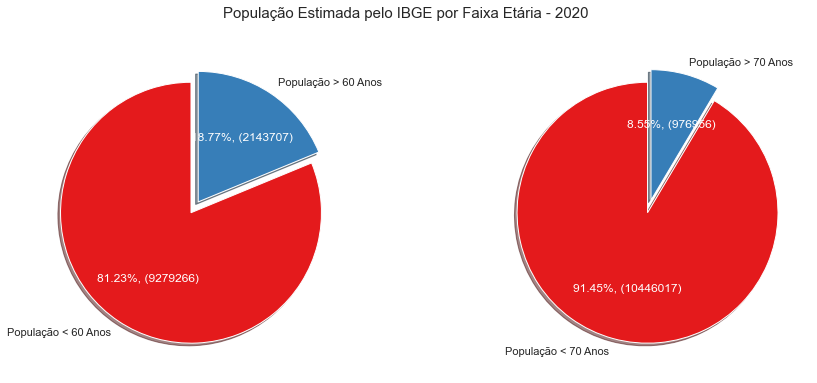

In [67]:
populacao_2020_60_plot = populacao_2020_60.stack()
populacao_2020_70_plot = populacao_2020_70.stack()

fig, axes = plt.subplots(1, 2, figsize = (15,6))
explode = (0, 0.1) 

_, _, autotexts = axes[0].pie(populacao_2020_60_plot, explode=explode, labels=populacao_60_label, autopct=lambda p:f'{p:.2f}%, ({p*sum(populacao_2020_60_plot)/100 :.0f})', shadow=True, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')

_, _, autotexts = axes[1].pie(populacao_2020_70_plot, explode=explode, labels=populacao_70_label, autopct=lambda p:f'{p:.2f}%, ({p*sum(populacao_2020_70_plot)/100 :.0f})', shadow=True, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')

    
# Utilizar o formato abaixo caso queria só mostrar o percentual
# autopct='%1.1f%%'        

fig.suptitle('População Estimada pelo IBGE por Faixa Etária - 2020', fontsize=15)

plt.show()

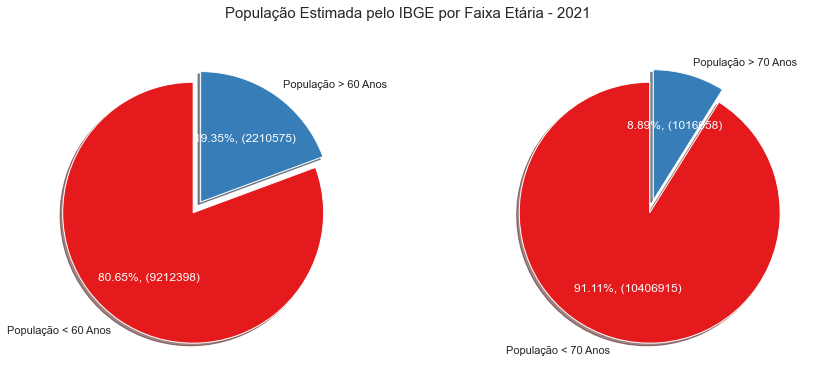

In [68]:
populacao_2021_60_plot = populacao_2021_60.stack()
populacao_2021_70_plot = populacao_2021_70.stack()

fig, axes = plt.subplots(1, 2, figsize = (15,6))
explode = (0, 0.1) 

_, _, autotexts = axes[0].pie(populacao_2021_60_plot, explode=explode, labels=populacao_60_label, autopct=lambda p:f'{p:.2f}%, ({p*sum(populacao_2020_60_plot)/100 :.0f})', shadow=True, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')

_, _, autotexts = axes[1].pie(populacao_2021_70_plot, explode=explode, labels=populacao_70_label, autopct=lambda p:f'{p:.2f}%, ({p*sum(populacao_2020_70_plot)/100 :.0f})', shadow=True, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')

    
# Utilizar o formato abaixo caso queria só mostrar o percentual
# autopct='%1.1f%%'        

fig.suptitle('População Estimada pelo IBGE por Faixa Etária - 2021', fontsize=15)

plt.show()

In [69]:
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_60_MEDIA_MOVEL_7'] = casos_de_covid_total_resultado["OBITOS_FAIXA_ETARIA_MENOR_60"].rolling(7).mean()
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_60_MEDIA_MOVEL_7'] = casos_de_covid_total_resultado["OBITOS_FAIXA_ETARIA_MAIOR_60"].rolling(7).mean()
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_60_MEDIA_MOVEL_7'] = casos_de_covid_total_resultado["CASOS_FAIXA_ETARIA_MENOR_60"].rolling(7).mean()
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_60_MEDIA_MOVEL_7'] = casos_de_covid_total_resultado["CASOS_FAIXA_ETARIA_MAIOR_60"].rolling(7).mean()
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_70_MEDIA_MOVEL_7'] = casos_de_covid_total_resultado["OBITOS_FAIXA_ETARIA_MENOR_70"].rolling(7).mean()
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_70_MEDIA_MOVEL_7'] = casos_de_covid_total_resultado["OBITOS_FAIXA_ETARIA_MAIOR_70"].rolling(7).mean()
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_70_MEDIA_MOVEL_7'] = casos_de_covid_total_resultado["CASOS_FAIXA_ETARIA_MENOR_70"].rolling(7).mean()
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_70_MEDIA_MOVEL_7'] = casos_de_covid_total_resultado["CASOS_FAIXA_ETARIA_MAIOR_70"].rolling(7).mean()

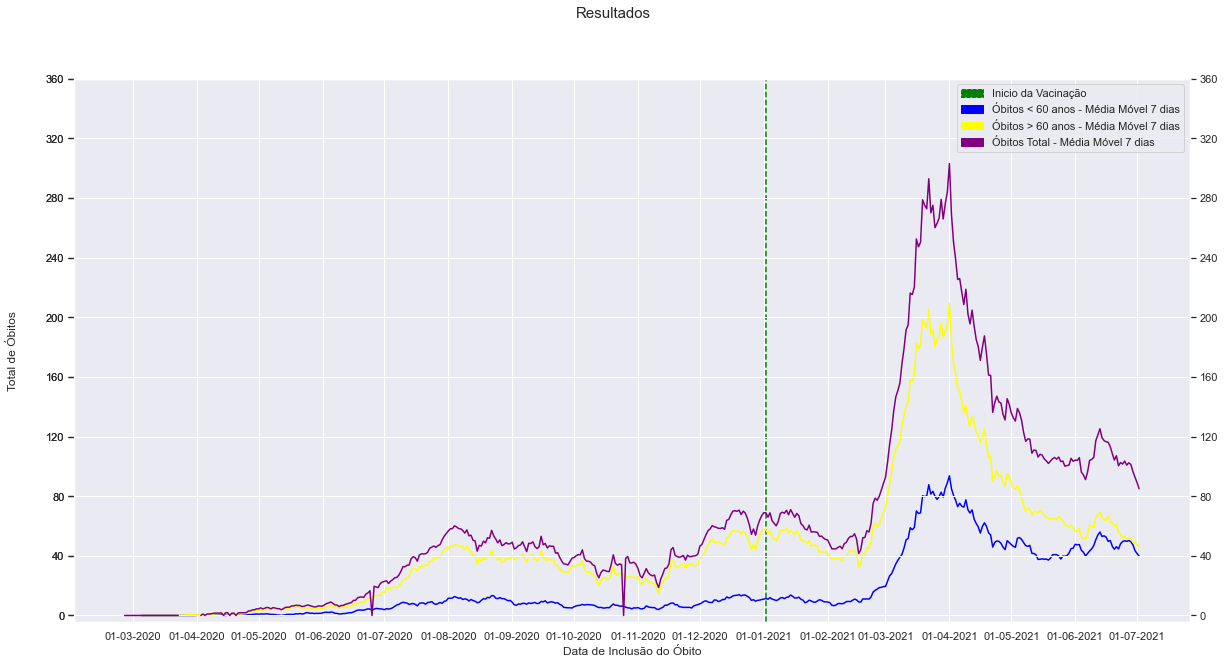

In [103]:
sns.set_theme(style='darkgrid')
fig, ax1 = plt.subplots(1, 1, figsize = (20,10))
sns.set_palette(palette)

ax2 = ax1.twinx()  
ax3 = ax1.twinx()  

ax1.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.OBITOS_FAIXA_ETARIA_MENOR_60_MEDIA_MOVEL_7, color='blue') 
ax2.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.OBITOS_FAIXA_ETARIA_MAIOR_60_MEDIA_MOVEL_7, color='yellow') 
ax3.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.OBITOS_MEDIA_MOVEL_7, color='purple') 

date_form = mdates.DateFormatter('%d-%m-%Y')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(date_form)

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()
ax3.yaxis.tick_left()

ax1.set_yticks( range(00, 400, 40) )
ax2.set_yticks( range(0, 400, 40) )
ax3.set_yticks( range(0, 400, 40) )

ax1.yaxis.set_label_coords(-0.05, 0.5)

ax2.set_ylim(ax1.get_ylim())
ax3.set_ylim(ax1.get_ylim())

ax1.set_xlabel('Data de Inclusão do Óbito', fontsize=12)
ax1.set_ylabel('Total de Óbitos', fontsize=12)

fig.suptitle('Resultados', fontsize=15)

ax1.axvline(x=datetime(2021, 1, 2), color="green", linestyle="--")

green_patch = mpatches.Patch(color='green', label='Inicio da Vacinação', linestyle="--")
blue_patch = mpatches.Patch(color='blue', label='Óbitos < 60 anos - Média Móvel 7 dias')
yellow_patch = mpatches.Patch(color='yellow', label='Óbitos > 60 anos - Média Móvel 7 dias')
purple_patch = mpatches.Patch(color='purple', label='Óbitos Total - Média Móvel 7 dias')

plt.legend(handles=[green_patch, blue_patch, yellow_patch, purple_patch])

plt.savefig('Media_Movel_de_Obitos_60.png', dpi=300)

plt.show()

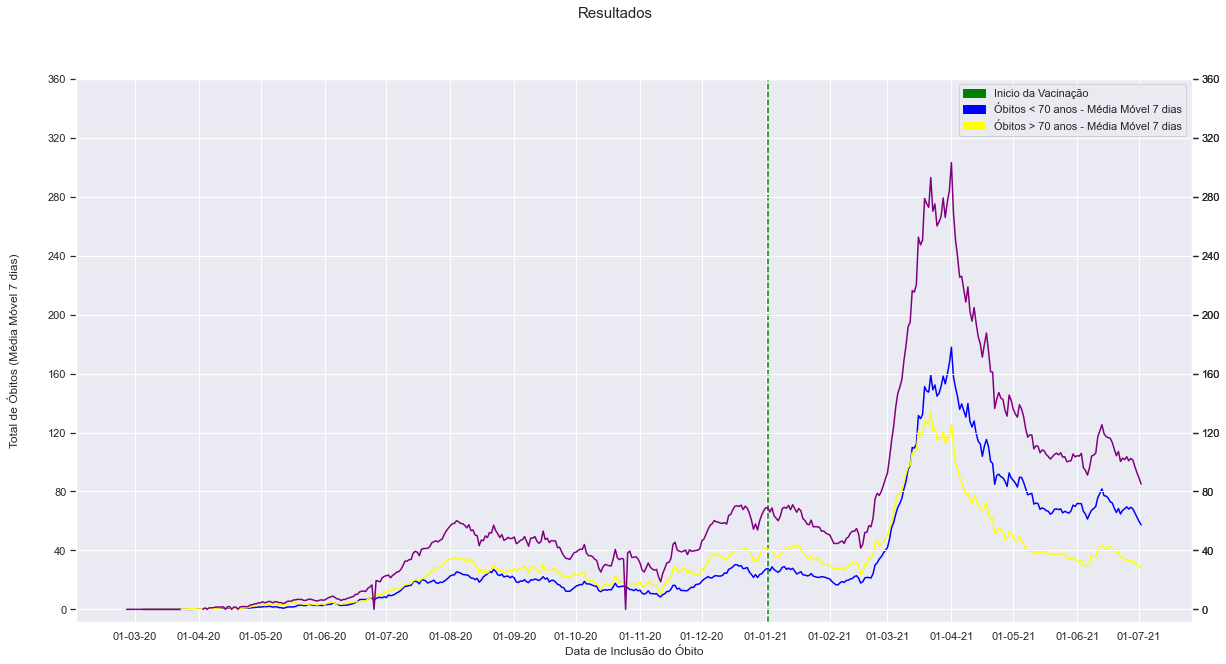

In [104]:
sns.set_theme(style='darkgrid')
fig, ax1 = plt.subplots(1, 1, figsize = (20,10))
sns.set_palette(palette)

ax2 = ax1.twinx()  
ax3 = ax1.twinx()  

ax1.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.OBITOS_FAIXA_ETARIA_MENOR_70_MEDIA_MOVEL_7, color='blue') 
ax2.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.OBITOS_FAIXA_ETARIA_MAIOR_70_MEDIA_MOVEL_7, color='yellow') 
ax3.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.OBITOS_MEDIA_MOVEL_7, color='purple') 

date_form = mdates.DateFormatter('%d-%m-%y')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(date_form)

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

ax1.set_yticks( range(0, 400, 40) )
ax2.set_yticks( range(0, 400, 40) )
ax3.set_yticks( range(0, 400, 40) )

ax1.yaxis.set_label_coords(-0.05, 0.5)

ax2.set_ylim(ax1.get_ylim())
ax3.set_ylim(ax1.get_ylim())

ax1.set_xlabel('Data de Inclusão do Óbito', fontsize=12)
ax1.set_ylabel('Total de Óbitos (Média Móvel 7 dias)', fontsize=12)

fig.suptitle('Resultados', fontsize=15)

ax1.axvline(x=datetime(2021, 1, 2), color="green", linestyle="--")

green_patch = mpatches.Patch(color='green', label='Inicio da Vacinação')
blue_patch = mpatches.Patch(color='blue', label='Óbitos < 70 anos - Média Móvel 7 dias')
yellow_patch = mpatches.Patch(color='yellow', label='Óbitos > 70 anos - Média Móvel 7 dias')

plt.legend(handles=[green_patch, blue_patch, yellow_patch])

plt.savefig('Media_Movel_de_Obitos_70.png', dpi=300)

plt.show()


In [72]:
casos_de_covid_total_resultado.head(500)

,DATA_CONFIRMACAO,TOTAL,MEDIA_MOVEL_7,TOTAL_ACUMULADO,TOTAL_OBITOS,TOTAL_OBITOS_ACUMULADO,OBITOS_MEDIA_MOVEL_7,CASOS_FAIXA_ETARIA_MENOR_60,CASOS_FAIXA_ETARIA_MENOR_60_ACUMULADO,CASOS_FAIXA_ETARIA_MAIOR_60,...,POPULACAO_2020_MAIOR_70,POPULACAO_2021_MAIOR_70,OBITOS_FAIXA_ETARIA_MENOR_60_MEDIA_MOVEL_7,OBITOS_FAIXA_ETARIA_MAIOR_60_MEDIA_MOVEL_7,CASOS_FAIXA_ETARIA_MENOR_60_MEDIA_MOVEL_7,CASOS_FAIXA_ETARIA_MAIOR_60_MEDIA_MOVEL_7,OBITOS_FAIXA_ETARIA_MENOR_70_MEDIA_MOVEL_7,OBITOS_FAIXA_ETARIA_MAIOR_70_MEDIA_MOVEL_7,CASOS_FAIXA_ETARIA_MENOR_70_MEDIA_MOVEL_7,CASOS_FAIXA_ETARIA_MAIOR_70_MEDIA_MOVEL_7
0,2020-02-26,1,NaN,0,0,0,0.000000,1,0,0,...,976956,1019941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-29,1,NaN,1,0,0,0.000000,1,1,0,...,976956,1019941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-01,8,NaN,9,0,0,0.000000,5,6,3,...,976956,1019941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-02,4,NaN,13,0,0,0.000000,3,9,1,...,976956,1019941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-03,3,NaN,16,0,0,0.000000,2,11,1,...,976956,1019941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,2021-06-28,1768,1688.857143,1227217,41,31161,101.285714,1544,1028391,224,...,976956,1019941,49.428571,51.857143,1469.571429,219.285714,68.142857,33.142857,1593.571429,95.285714
486,2021-06-29,888,1463.428571,1228105,122,31283,96.571429,759,1029150,129,...,976956,1019941,47.428571,49.142857,1267.000000,196.428571,65.285714,31.285714,1380.571429,82.857143
487,2021-06-30,938,1255.714286,1229043,118,31401,92.714286,816,1029966,122,...,976956,1019941,43.428571,49.285714,1081.571429,174.142857,62.285714,30.428571,1183.142857,72.571429
488,2021-07-01,693,1079.000000,1229736,99,31500,89.142857,610,1030576,83,...,976956,1019941,41.571429,47.571429,929.285714,149.714286,59.714286,29.428571,1016.285714,62.714286


In [73]:
casos_mortalidade_vacinacao = casos_de_covid_rw.groupby('DATA_CONFIRMACAO', as_index=False).agg(TOTAL=pd.NamedAgg(column='DATA_CONFIRMACAO', aggfunc=len))
casos_mortalidade_vacinacao.sort_values(by=['DATA_CONFIRMACAO'], inplace=True)

In [74]:
casos_mortalidade_vacinacao.head(500)

,DATA_CONFIRMACAO,TOTAL
0,2020-02-26,1
1,2020-02-29,1
2,2020-03-01,8
3,2020-03-02,4
4,2020-03-03,3
...,...,...
485,2021-06-28,1768
486,2021-06-29,888
487,2021-06-30,938
488,2021-07-01,693


In [75]:
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_60_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_60_ACUMULADO_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_60_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_70_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_70_ACUMULADO_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_70_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO_PERCENTUAL'] = 0.0

casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_60_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_60_ACUMULADO_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_60_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_70_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_70_ACUMULADO_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_70_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO_PERCENTUAL'] = 0.0

In [76]:
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_60'].fillna(0)
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_60'].fillna(0)
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_70'].fillna(0)
casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_70'].fillna(0)
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_60'].fillna(0)
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_60'].fillna(0)
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_70'].fillna(0)
casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_70'].fillna(0)

0       0
1       0
2       0
3       0
4       0
       ..
485    14
486    36
487    39
488    35
489    30
Name: OBITOS_FAIXA_ETARIA_MAIOR_70, Length: 490, dtype: int64

In [77]:
for ind in casos_de_covid_total_resultado.index:
    
    data_confirmacao = casos_de_covid_total_resultado['DATA_CONFIRMACAO'][ind]

    if casos_de_covid_total_resultado['TOTAL_ACUMULADO'][ind] > 0:

        casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_60_PERCENTUAL'][ind] = int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_60'][ind] / casos_de_covid_total_resultado['TOTAL'][ind])
        casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_60_ACUMULADO_PERCENTUAL'][ind] = float(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_60_ACUMULADO'][ind] / casos_de_covid_total_resultado['TOTAL_ACUMULADO'][ind]) * 100 
        casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_60_PERCENTUAL'][ind] = int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_60'][ind] / casos_de_covid_total_resultado['TOTAL'][ind])
        casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO_PERCENTUAL'][ind] = float(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO'][ind] / casos_de_covid_total_resultado['TOTAL_ACUMULADO'][ind]) * 100
        casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_70_PERCENTUAL'][ind] = int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_70'][ind] / casos_de_covid_total_resultado['TOTAL'][ind])
        casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_70_ACUMULADO_PERCENTUAL'][ind] = float( casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MENOR_70_ACUMULADO'][ind] / casos_de_covid_total_resultado['TOTAL_ACUMULADO'][ind]) * 100
        casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_70_PERCENTUAL'][ind] = int(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_70'][ind] / casos_de_covid_total_resultado['TOTAL'][ind])
        casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO_PERCENTUAL'][ind] = float(casos_de_covid_total_resultado['CASOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO'][ind] / casos_de_covid_total_resultado['TOTAL_ACUMULADO'][ind]) * 100

    if casos_de_covid_total_resultado['TOTAL_OBITOS_ACUMULADO'][ind] > 0:

        casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_60_PERCENTUAL'][ind] = int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_60'][ind] / casos_de_covid_total_resultado['TOTAL'][ind])
        casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_60_ACUMULADO_PERCENTUAL'][ind] = float( casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_60_ACUMULADO'][ind] / casos_de_covid_total_resultado['TOTAL_OBITOS_ACUMULADO'][ind]) * 100
        casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_60_PERCENTUAL'][ind] = int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_60'][ind] / casos_de_covid_total_resultado['TOTAL'][ind])
        casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO_PERCENTUAL'][ind] = float(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO'][ind] / casos_de_covid_total_resultado['TOTAL_OBITOS_ACUMULADO'][ind]) * 100
        casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_70_PERCENTUAL'][ind] = int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_70'][ind] / casos_de_covid_total_resultado['TOTAL'][ind])
        casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_70_ACUMULADO_PERCENTUAL'][ind] = float( casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MENOR_70_ACUMULADO'][ind] / casos_de_covid_total_resultado['TOTAL_OBITOS_ACUMULADO'][ind]) * 100
        casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_70_PERCENTUAL'][ind] = int(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_70'][ind] / casos_de_covid_total_resultado['TOTAL'][ind])
        casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO_PERCENTUAL'][ind] = float(casos_de_covid_total_resultado['OBITOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO'][ind] / casos_de_covid_total_resultado['TOTAL_OBITOS_ACUMULADO'][ind]) * 100

In [78]:
casos_de_covid_total_resultado['VACINADOS_1_DOSE_FAIXA_ETARIA_MENOR_60_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['VACINADOS_1_DOSE_FAIXA_ETARIA_MAIOR_60_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['VACINADOS_1_DOSE_FAIXA_ETARIA_MENOR_70_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['VACINADOS_1_DOSE_FAIXA_ETARIA_MAIOR_70_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['VACINADOS_2_DOSE_FAIXA_ETARIA_MENOR_60_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['VACINADOS_2_DOSE_FAIXA_ETARIA_MAIOR_60_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['VACINADOS_2_DOSE_FAIXA_ETARIA_MENOR_70_PERCENTUAL'] = 0.0
casos_de_covid_total_resultado['VACINADOS_2_DOSE_FAIXA_ETARIA_MAIOR_70_PERCENTUAL'] = 0.0

for ind in casos_de_covid_total_resultado.index:
    
    data_confirmacao = casos_de_covid_total_resultado['DATA_CONFIRMACAO'][ind]

    if casos_de_covid_total_resultado['TOTAL_ACUMULADO'][ind] > 0:

        casos_de_covid_total_resultado['VACINADOS_1_DOSE_FAIXA_ETARIA_MENOR_60_PERCENTUAL'][ind] = float(casos_de_covid_total_resultado['TOTAL_VACINADOS_1_MENOR_60_ACUMULADO'][ind] / casos_de_covid_total_resultado['POPULACAO_2021_MENOR_60'][ind]) * 100 

        casos_de_covid_total_resultado['VACINADOS_1_DOSE_FAIXA_ETARIA_MAIOR_60_PERCENTUAL'][ind] = float(casos_de_covid_total_resultado['TOTAL_VACINADOS_1_MAIOR_60_ACUMULADO'][ind] / casos_de_covid_total_resultado['POPULACAO_2021_MAIOR_60'][ind]) * 100 
        
        casos_de_covid_total_resultado['VACINADOS_1_DOSE_FAIXA_ETARIA_MENOR_70_PERCENTUAL'][ind] = float(casos_de_covid_total_resultado['TOTAL_VACINADOS_1_MENOR_70_ACUMULADO'][ind] / casos_de_covid_total_resultado['POPULACAO_2021_MENOR_70'][ind]) * 100 

        casos_de_covid_total_resultado['VACINADOS_1_DOSE_FAIXA_ETARIA_MAIOR_70_PERCENTUAL'][ind] = float(casos_de_covid_total_resultado['TOTAL_VACINADOS_1_MAIOR_70_ACUMULADO'][ind] / casos_de_covid_total_resultado['POPULACAO_2021_MAIOR_70'][ind]) * 100 

        casos_de_covid_total_resultado['VACINADOS_2_DOSE_FAIXA_ETARIA_MENOR_60_PERCENTUAL'][ind] = float(casos_de_covid_total_resultado['TOTAL_VACINADOS_2_MENOR_60_ACUMULADO'][ind] / casos_de_covid_total_resultado['POPULACAO_2021_MENOR_60'][ind]) * 100 

        casos_de_covid_total_resultado['VACINADOS_2_DOSE_FAIXA_ETARIA_MAIOR_60_PERCENTUAL'][ind] = float(casos_de_covid_total_resultado['TOTAL_VACINADOS_2_MAIOR_60_ACUMULADO'][ind] / casos_de_covid_total_resultado['POPULACAO_2021_MAIOR_60'][ind]) * 100 
        
        casos_de_covid_total_resultado['VACINADOS_2_DOSE_FAIXA_ETARIA_MENOR_70_PERCENTUAL'][ind] = float(casos_de_covid_total_resultado['TOTAL_VACINADOS_2_MENOR_70_ACUMULADO'][ind] / casos_de_covid_total_resultado['POPULACAO_2021_MENOR_70'][ind]) * 100 

        casos_de_covid_total_resultado['VACINADOS_2_DOSE_FAIXA_ETARIA_MAIOR_70_PERCENTUAL'][ind] = float(casos_de_covid_total_resultado['TOTAL_VACINADOS_2_MAIOR_70_ACUMULADO'][ind] / casos_de_covid_total_resultado['POPULACAO_2021_MAIOR_70'][ind]) * 100 


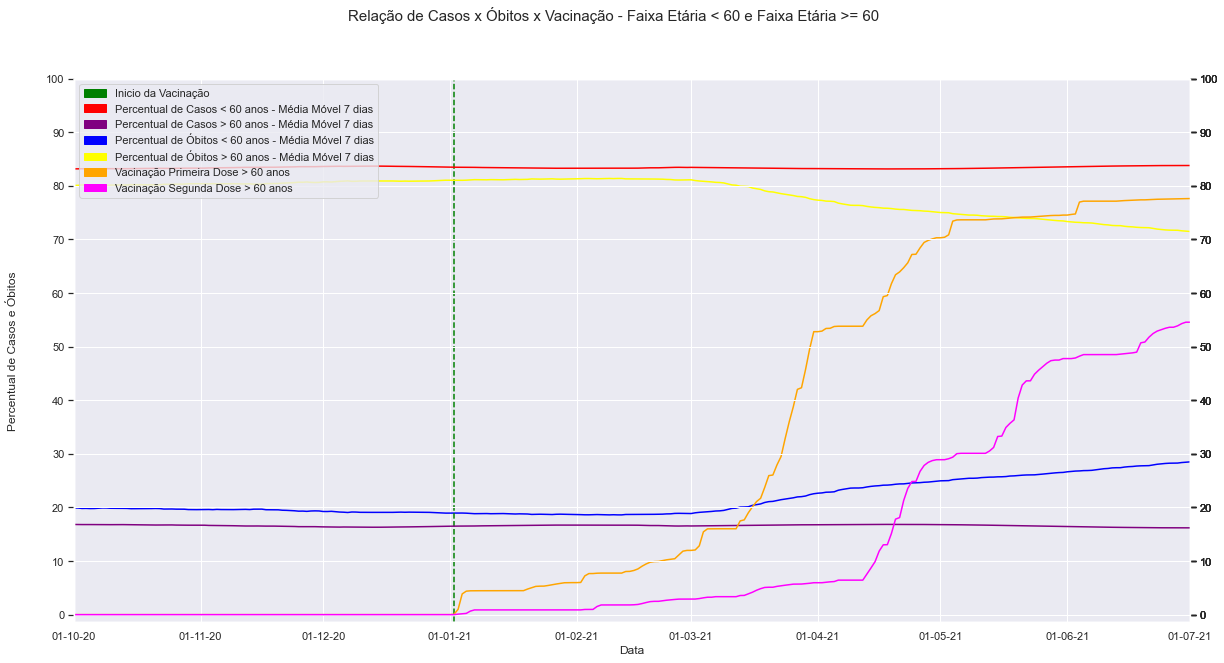

In [105]:
sns.set_theme(style='darkgrid')
fig, ax1 = plt.subplots(1, 1, figsize = (20,10))
sns.set_palette(palette)

ax2 = ax1.twinx()  
ax3 = ax1.twinx()  
ax4 = ax1.twinx()  
ax5 = ax1.twinx()  
ax6 = ax1.twinx()  

ax1.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.OBITOS_FAIXA_ETARIA_MENOR_60_ACUMULADO_PERCENTUAL, color='blue', label='Obitos < 60 anos') 
ax2.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.OBITOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO_PERCENTUAL, color='yellow', label='Obitos > 60 anos') 
ax3.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.CASOS_FAIXA_ETARIA_MENOR_60_ACUMULADO_PERCENTUAL, color='red', label='Casos < 60 anos') 
ax4.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.CASOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO_PERCENTUAL, color='purple', label='Casos > 60 anos') 
ax5.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.VACINADOS_1_DOSE_FAIXA_ETARIA_MAIOR_60_PERCENTUAL, color='orange', label='Vacinados 1° Dose > 60 anos') 
ax6.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.VACINADOS_2_DOSE_FAIXA_ETARIA_MAIOR_60_PERCENTUAL, color='magenta', label='Vacinados 2° Dose > 60 anos') 

date_form = mdates.DateFormatter('%d-%m-%y')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(date_form)

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

ax1.set_yticks( range(0, 110, 10) )
ax2.set_yticks( range(0, 110, 10) )
ax3.set_yticks( range(0, 110, 10) )
ax4.set_yticks( range(0, 110, 10) )
ax5.set_yticks( range(0, 110, 10) )
ax6.set_yticks( range(0, 110, 10) )

ax1.yaxis.set_label_coords(-0.05, 0.5)

ax2.set_ylim(ax1.get_ylim())
ax3.set_ylim(ax1.get_ylim())
ax4.set_ylim(ax1.get_ylim())
ax5.set_ylim(ax1.get_ylim())
ax6.set_ylim(ax1.get_ylim())


ax1.set_xlabel('Data', fontsize=12)
ax1.set_ylabel('Percentual de Casos e Óbitos', fontsize=12)

fig.suptitle('Relação de Casos x Óbitos x Vacinação - Faixa Etária < 60 e Faixa Etária >= 60', fontsize=15)

ax1.set_xlim([dt.date(2020, 10, 1), dt.date(2021, 7, 1)])

ax1.axvline(x=datetime(2021, 1, 2), color="green", linestyle="--")

green_patch = mpatches.Patch(color='green', label='Inicio da Vacinação')

red_patch = mpatches.Patch(color='red', label='Percentual de Casos < 60 anos - Média Móvel 7 dias')
purple_patch = mpatches.Patch(color='purple', label='Percentual de Casos > 60 anos - Média Móvel 7 dias')

blue_patch = mpatches.Patch(color='blue', label='Percentual de Óbitos < 60 anos - Média Móvel 7 dias')
yellow_patch = mpatches.Patch(color='yellow', label='Percentual de Óbitos > 60 anos - Média Móvel 7 dias')

orange_patch = mpatches.Patch(color='orange', label='Vacinação Primeira Dose > 60 anos')
magenta_patch = mpatches.Patch(color='magenta', label='Vacinação Segunda Dose > 60 anos')

plt.legend(handles=[green_patch, red_patch, purple_patch, blue_patch, yellow_patch, orange_patch, magenta_patch], loc='upper left')

plt.savefig('Resultados_Cenario_1.png', dpi=300)

plt.show()

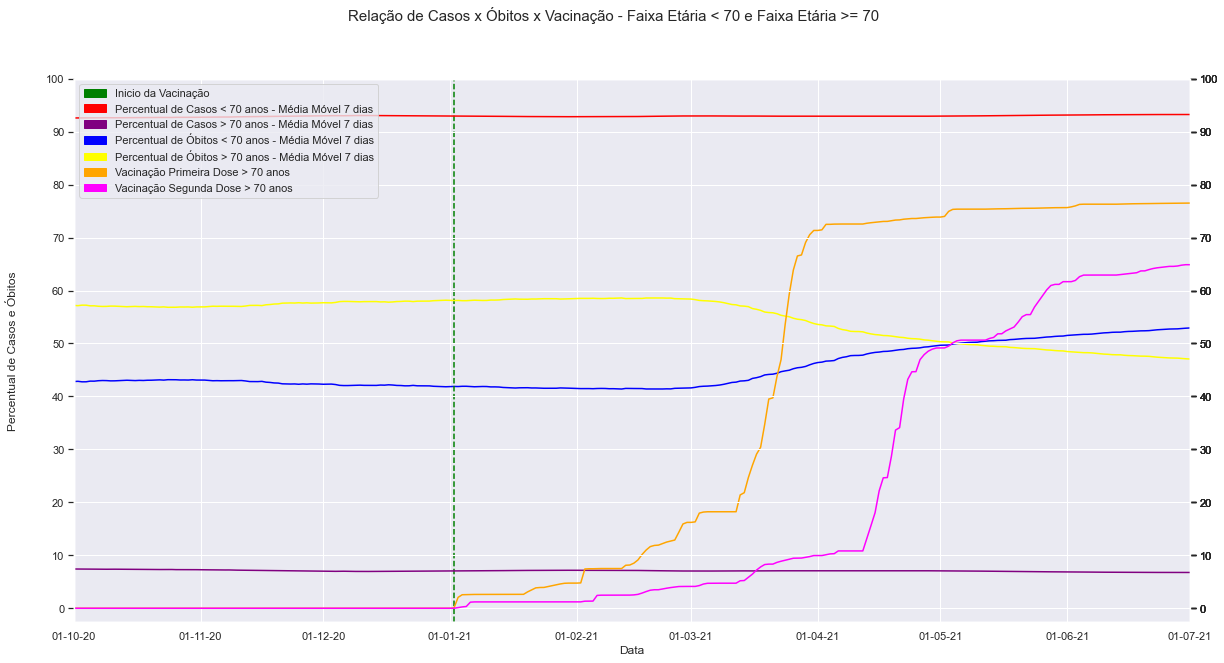

In [106]:
sns.set_theme(style='darkgrid')
fig, ax1 = plt.subplots(1, 1, figsize = (20,10))
sns.set_palette(palette)

ax2 = ax1.twinx()  
ax3 = ax1.twinx()  
ax4 = ax1.twinx()  
ax5 = ax1.twinx()  
ax6 = ax1.twinx()  

ax1.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.OBITOS_FAIXA_ETARIA_MENOR_70_ACUMULADO_PERCENTUAL, color='blue', label='Obitos < 70 anos') 
ax2.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.OBITOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO_PERCENTUAL, color='yellow', label='Obitos > 70 anos') 
ax3.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.CASOS_FAIXA_ETARIA_MENOR_70_ACUMULADO_PERCENTUAL, color='red', label='Casos < 70 anos') 
ax4.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.CASOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO_PERCENTUAL, color='purple', label='Casos > 70 anos') 
ax5.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.VACINADOS_1_DOSE_FAIXA_ETARIA_MAIOR_70_PERCENTUAL, color='orange', label='Vacinados 1° Dose > 70 anos') 
ax6.plot(casos_de_covid_total_resultado.DATA_CONFIRMACAO, casos_de_covid_total_resultado.VACINADOS_2_DOSE_FAIXA_ETARIA_MAIOR_70_PERCENTUAL, color='magenta', label='Vacinados 2° Dose > 70 anos') 


date_form = mdates.DateFormatter('%d-%m-%y')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(date_form)

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

ax1.set_yticks( range(0, 110, 10) )
ax2.set_yticks( range(0, 110, 10) )
ax3.set_yticks( range(0, 110, 10) )
ax4.set_yticks( range(0, 110, 10) )
ax5.set_yticks( range(0, 110, 10) )
ax6.set_yticks( range(0, 110, 10) )

ax1.yaxis.set_label_coords(-0.05, 0.5)

ax2.set_ylim(ax1.get_ylim())
ax3.set_ylim(ax1.get_ylim())
ax4.set_ylim(ax1.get_ylim())
ax5.set_ylim(ax1.get_ylim())
ax6.set_ylim(ax1.get_ylim())


ax1.set_xlabel('Data', fontsize=12)
ax1.set_ylabel('Percentual de Casos e Óbitos', fontsize=12)

fig.suptitle('Relação de Casos x Óbitos x Vacinação - Faixa Etária < 70 e Faixa Etária >= 70', fontsize=15)

ax1.set_xlim([dt.date(2020, 10, 1), dt.date(2021, 7, 1)])

ax1.axvline(x=datetime(2021, 1, 2), color="green", linestyle="--")

green_patch = mpatches.Patch(color='green', label='Inicio da Vacinação')

red_patch = mpatches.Patch(color='red', label='Percentual de Casos < 70 anos - Média Móvel 7 dias')
purple_patch = mpatches.Patch(color='purple', label='Percentual de Casos > 70 anos - Média Móvel 7 dias')

blue_patch = mpatches.Patch(color='blue', label='Percentual de Óbitos < 70 anos - Média Móvel 7 dias')
yellow_patch = mpatches.Patch(color='yellow', label='Percentual de Óbitos > 70 anos - Média Móvel 7 dias')

orange_patch = mpatches.Patch(color='orange', label='Vacinação Primeira Dose > 70 anos')
magenta_patch = mpatches.Patch(color='magenta', label='Vacinação Segunda Dose > 70 anos')

plt.legend(handles=[green_patch, red_patch, purple_patch, blue_patch, yellow_patch, orange_patch, magenta_patch], loc='upper left')

plt.savefig('Resultados_Cenario_2.png', dpi=300)

plt.show()

In [ ]:
datas = pd.date_range(start="2020-03-01",end="2021-07-01", freq='MS')

df = casos_de_covid_total_resultado[casos_de_covid_total_resultado['DATA_CONFIRMACAO'].isin(datas)].loc[:,['DATA_CONFIRMACAO', 'TOTAL_ACUMULADO', 'TOTAL_OBITOS_ACUMULADO', 'CASOS_FAIXA_ETARIA_MENOR_70_ACUMULADO_PERCENTUAL',  'CASOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO_PERCENTUAL', 'OBITOS_FAIXA_ETARIA_MENOR_70_ACUMULADO_PERCENTUAL',  'OBITOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO_PERCENTUAL', 
'VACINADOS_1_DOSE_FAIXA_ETARIA_MENOR_60_PERCENTUAL', 'VACINADOS_1_DOSE_FAIXA_ETARIA_MAIOR_60_PERCENTUAL', 'VACINADOS_1_DOSE_FAIXA_ETARIA_MENOR_70_PERCENTUAL',
'VACINADOS_1_DOSE_FAIXA_ETARIA_MAIOR_70_PERCENTUAL', 'VACINADOS_2_DOSE_FAIXA_ETARIA_MENOR_60_PERCENTUAL', 'VACINADOS_2_DOSE_FAIXA_ETARIA_MAIOR_60_PERCENTUAL',
'VACINADOS_2_DOSE_FAIXA_ETARIA_MENOR_70_PERCENTUAL', 'VACINADOS_2_DOSE_FAIXA_ETARIA_MAIOR_70_PERCENTUAL']]

df.to_csv('Total de Casos - 70 anos.csv', sep = ';', float_format='%.2f')

In [97]:
datas = pd.date_range(start="2020-06-01",end="2020-06-01")
df = casos_de_covid_total_resultado[casos_de_covid_total_resultado['DATA_CONFIRMACAO'].isin(datas)].loc[:,['CASOS_FAIXA_ETARIA_MENOR_70_ACUMULADO', 'CASOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO', 'OBITOS_FAIXA_ETARIA_MENOR_70_ACUMULADO', 'OBITOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO']]

casos_menor_70 = int(df['CASOS_FAIXA_ETARIA_MENOR_70_ACUMULADO'])
casos_maior_70 = int(df['CASOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO'])
obitos_menor_70 = int(df['OBITOS_FAIXA_ETARIA_MENOR_70_ACUMULADO'])
obitos_maior_70 = int(df['OBITOS_FAIXA_ETARIA_MAIOR_70_ACUMULADO'])

casos_percentual_menor_70 = (casos_menor_70 / (casos_menor_70 + casos_maior_70)) * 100
casos_percentual_maior_70 = (casos_maior_70 / (casos_menor_70 + casos_maior_70)) * 100

obitos_percentual_menor_70 = (obitos_menor_70 / (obitos_menor_70 + obitos_maior_70)) * 100
obitos_percentual_maior_70 = (obitos_maior_70 / (obitos_menor_70 + obitos_maior_70)) * 100

letalidade_menor_70 = (obitos_menor_70 / casos_menor_70) * 100
letalidade_maior_70 = (obitos_maior_70 / casos_maior_70) * 100

print('Menor 70')
print(casos_menor_70)
print(casos_percentual_menor_70)

print(obitos_menor_70)
print(obitos_percentual_menor_70)

print(letalidade_menor_70)

print('Maior 70')
print(casos_maior_70)
print(casos_percentual_maior_70) 

print(obitos_maior_70)
print(obitos_percentual_maior_70)

print(letalidade_maior_70)


Menor 70
11789
92.73184928813026
97
38.3399209486166
0.8228009161082364
Maior 70
924
7.2681507118697395
156
61.6600790513834
16.883116883116884


In [98]:
datas = pd.date_range(start="2020-06-01",end="2020-06-01")
df = casos_de_covid_total_resultado[casos_de_covid_total_resultado['DATA_CONFIRMACAO'].isin(datas)].loc[:,['CASOS_FAIXA_ETARIA_MENOR_60_ACUMULADO', 'CASOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO', 'OBITOS_FAIXA_ETARIA_MENOR_60_ACUMULADO', 'OBITOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO']]

casos_menor_60 = int(df['CASOS_FAIXA_ETARIA_MENOR_60_ACUMULADO'])
casos_maior_60 = int(df['CASOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO'])
obitos_menor_60 = int(df['OBITOS_FAIXA_ETARIA_MENOR_60_ACUMULADO'])
obitos_maior_60 = int(df['OBITOS_FAIXA_ETARIA_MAIOR_60_ACUMULADO'])

casos_percentual_menor_60 = (casos_menor_60 / (casos_menor_60 + casos_maior_60)) * 100
casos_percentual_maior_60 = (casos_maior_60 / (casos_menor_60 + casos_maior_60)) * 100

obitos_percentual_menor_60 = (obitos_menor_60 / (obitos_menor_60 + obitos_maior_60)) * 100
obitos_percentual_maior_60 = (obitos_maior_60 / (obitos_menor_60 + obitos_maior_60)) * 100

letalidade_menor_60 = (obitos_menor_60 / casos_menor_60) * 100
letalidade_maior_60 = (obitos_maior_60 / casos_maior_60) * 100

print('Menor 60')
print(casos_menor_60)
print(casos_percentual_menor_60)

print(obitos_menor_60)
print(obitos_percentual_menor_60)

print(letalidade_menor_60)

print('Maior 60')
print(casos_maior_60)
print(casos_percentual_maior_60) 

print(obitos_maior_60)
print(obitos_percentual_maior_60)

print(letalidade_maior_60)

Menor 60
10796
84.92094706206245
47
18.57707509881423
0.4353464246017043
Maior 60
1917
15.079052937937545
206
81.42292490118577
10.745957224830464
